# Notes about simulation:

**Running info**
- 2250 simulations
- week queue

**EA params**
- 160 generations
- 250 individuals
- 0.1 mutation rate
- 0.5 crossover rate

**Parameter search space**
- beta_0,    k1, k3, k5, k7,    k2, k4, k6, k8,    kn, kc,    K_1, K_3, K_5, K_7,    K_2, K_4, K_6, K_8
- minimums = [ -4,   -2, -2, -2, -2,   -2, -2, -2, -2,   -2, -2,     -2, -2, -2, -2,    -2, -2, -2, -2]
- maximums = [4.5,    4,  4,  4,  4,    4,  4,  4,  4,    4,  4,     4,   4,  4,  4,     4,  4,  4,  4]

**Mean of Mean Square Error of the top 2.5% of Individuals** 
- 1404.57196018


$$MAP3K_I = MAP3K_t-MAP3K$$
$$MAP2K_I = MAP2K_t-MAP2K$$
$$MAPK_I = MAPK_t-MAPK$$


$$\dfrac{dMAP3K}{dt} = \dfrac{ s}{1+\dfrac{MAPK}{\beta}} \cdot \dfrac{k1\cdot MAP3K_I}{K_1 + MAP3K_I} - \dfrac{k2\cdot MAP3K}{K_2+MAP3K}$$

$$\dfrac{dMAP2K}{dt} = \dfrac{k3\cdot MAP3K\cdot MAP2K_I}{K_3 + MAP2K_I} - \dfrac{k4\cdot MAP2K}{K_4+MAP2K}$$

$$\dfrac{dMAPK}{dt} = \dfrac{k5\cdot MAP2K\cdot MAPK_I}{K_5 + MAPK_I} - \dfrac{k6\cdot MAPK}{K_6+MAPK}$$


# Import packages and set settings

In [ ]:
%matplotlib inline
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
import math
import pandas as pd
from scipy.integrate import odeint
import os

In [ ]:
# plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [10.0, 8.0]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['legend.fontsize'] = 14
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

In [ ]:
sns.palplot(sns.husl_palette(10, l=.7))
palette_husl = sns.husl_palette(10, l=.7)
# palette_husl.as_hex()

# Load data to fit to

In [ ]:
wt_folder = '../data/MAPK activation/WT'
t100a_folder = '../data/MAPK activation/T100A'

def load_csv_data(folder):
    data = []
    for csv in pathlib.Path(folder).glob('*.csv'):
        f_data = pd.read_csv(csv)
        time = f_data['Time'].tolist()
        f_data=f_data.set_index('Time')
        f_data = f_data.mean(axis=1)
        f_data = f_data.tolist()
        data.append(f_data)
    return time, data

mapk_time, mapk_wt_data = load_csv_data(wt_folder)
mapk_time, mapk_t100a_data = load_csv_data(t100a_folder)

scorefxn_data = [mapk_wt_data, mapk_t100a_data]

# Supporting Functions

In [315]:
# def scorefxn1(scorefxn_time, scorefxn_data, inits, params_constants,
#               learned_params, time, plot_bool):
#     mse_total = 0
#     arr_params_IP = convert_individual(learned_params, arr_conversion_matrix)

#     for sig, MAPK_wt_data, MAPK_t100a_data in zip(params_constants[-1], scorefxn_data[0], scorefxn_data[1]):
#         params_constants = params_constants[:-1]+[sig]

#         # WT simulation
#         data = simulate_wt_experiment(inits, params_constants, arr_params_IP, time)
#         active = (data[:,2] + data[:,3])/params_constants[2]*100
#         # get index of time points closest
#         idx_closest_time_points = []
#         for each_time in scorefxn_time:
#             closest_idx = min(range(len(time)),
#                               key = lambda i: abs(time[i] - each_time))
#             idx_closest_time_points.append(closest_idx)
#         # use indexes of time points to get data points to score against
#         _scorefxn_data_active = active[[idx_closest_time_points]]
#         error_active = ((MAPK_wt_data - _scorefxn_data_active)**2).mean()
#         mse_total += error_active

#         # T100A simulation
#         data = simulate_t100a_experiment(inits, params_constants, arr_params_IP, time)
#         active = (data[:,2] + data[:,3])/params_constants[2]*100
#         idx_closest_time_points = []
#         for each_time in scorefxn_time:
#             closest_idx = min(range(len(time)),
#                               key = lambda i: abs(time[i] - each_time))
#             idx_closest_time_points.append(closest_idx)
#         _scorefxn_data_active = active[[idx_closest_time_points]]
#         error_active = ((MAPK_t100a_data - _scorefxn_data_active)**2).mean()
#         mse_total += error_active
#     return mse_total


# def scorefxn_helper(individual):
#     # just a helper function that pulls all of scorefxn1 dependencies together
#     # note the (), <--using single optimization in DEAP for now
#     # scorefxn1 is taking care of the multiple optimizations for now
#     return scorefxn1(mapk_time, scorefxn_data, inits, params_constants, individual, time, False),

def molarity_conversion(molecules):
    Na = 6.02214076*10**23
    cell_volume = 44
    return molecules/(Na*cell_volume*10**-15)*1000000

def gather_simulated_data(folder, gen, runs):
    mse = []
    params_from_file = []

    empty_data = 0
    for loaded_data in pathlib.Path(folder).glob('*.pickled'):
        if os.path.getsize(loaded_data) > 0:
            with open(loaded_data, 'rb') as f:
                new_data = pickle.load(f)
                mse.append(np.asarray(new_data[0]))
                params_from_file.append(np.asarray(new_data[1]))
        else:
            empty_data += 1

    top = round((runs-empty_data)*0.05)
    plt_top = round((runs-empty_data)*0.01)      

    new_params = []
    last_mses = []
    for i in range(len(params_from_file)):
        new_params.append(params_from_file[i][gen])
        last_mses.append(mse[i][gen])
    last_mses = np.asarray(last_mses)
    new_params = np.asarray(new_params)
    new_params = new_params.T

    idx_top = last_mses.argsort()[:top]

    top_params = [([new_params[i][x] for i in range(len(new_params))]) for x in idx_top]
    # top_params = []
    # for idx in idx_top:
    #     top_params.append(params_from_file[idx][100])

    print('Best MSE: ' + str(np.min([mse[idx][gen] for idx in idx_top])))
    print('Mean MSE of top 5%: ' + str(np.mean([mse[idx][gen] for idx in idx_top])))
    return idx_top, top_params, top, plt_top, new_params, params_from_file, mse, last_mses

def plt_param_behaviors(mapk_wt_data, mapk_t100a_data, gen, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time):
    plt.clf()
    fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,18))


    # plot 1
    title_text = 'Gen ' + str(gen) + ' fit to WT'
    ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time', fontsize=20)
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20)
    color_palette = ['#000000','#ff0000','#FF8C00','#008000','#0000FF','#800080']
    
    for idx, wt_data in enumerate(mapk_wt_data):
        ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
        
    # plot 2
    title_text = 'Gen ' + str(gen) +  ' fit to T100A + inhib'
    ax2.set_title(title_text, fontsize=20)
    ax2.set_xlabel('Time', fontsize=20)
    
    for idx, t100a_data in enumerate(mapk_t100a_data):
        ax2.plot(mapk_time, t100a_data, '^', mew=2, markersize=10, color=color_palette[idx])

    # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    
    
    # plot evolutionary algorithm data on plots 1 and 2:
    unstable_wt = 0
    unstable_t100a = 0
    for idx in idx_top[:plt_top]:
        learned_params = params_from_file[idx][gen]
        for idx, sig in enumerate(params_constants[-1]):
            params_c = params_constants[:-1]+[sig]
            data = simulate_wt_experiment(initals, params_c, learned_params, time)
            active = data[:,2]/params_constants[2]*100
            if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
                ax1.plot(time, active, color=color_palette[idx])
            else:
                unstable_wt += 1
            data = simulate_t100a_experiment(initals, params_c, learned_params, time)
            active = data[:,2]/params_constants[2]*100
            if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
                ax2.plot(time, active, color=color_palette[idx])
            else:
                unstable_t100a += 1
    print('# of unstable WT experiments: ' + str(unstable_wt) + ' of ' + str(plt_top*6))
    print('# of unstable T100A experiments: ' + str(unstable_t100a) + ' of ' + str(plt_top*6))
    # ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    plt.show()
    
    #plot3 
def plt_mses_gen(gen,mse):
    plt.clf()
    fig, (ax3) = plt.subplots(1, 1, figsize=(12,8))
    pal = sns.color_palette("Greys", 20)[10:]
#     c_pal = sns.set_palette(pal)
    ax3.set_xlabel('Generation', fontsize=20)
    # ax2.set_ylabel('Sum of MSE', fontsize=20)
    # ax2.set_xlim([0,gen])
    # ax2.set_ylim([10**3,10**5])
#     pal = sns.set_palette(pal)
    sns.set_palette(pal)
    for idx in idx_top:
        ax3.semilogy([x for x in range(gen)], mse[idx][:gen])
    ax3.yaxis.grid(True)
    plt.show()
    

def plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M):
    plt.rcParams['figure.figsize'] = [12.0, 8.0]

    pal = sns.set_palette(colors)

    with sns.axes_style("whitegrid"):
        plt.bar(range(0,len(labelnames)),height=diff,bottom=minimums,align='center',tick_label=labelnames, color='#DCDCDC',alpha = 0.5)
        x = sns.swarmplot(x='param',y='vals', data = df_top_params_log_M)
        x.set_xticklabels(labelnames,rotation=45)
    #     ax.set_yscale("log")
    #     ax.set_ylim(0.00001,100000)
    #     ax4.set_xticks(locs)
    #     plt.xticklabels(labelnames, fontsize=18, rotation=90)
        plt.xlabel('Parameters', fontsize=20)
        plt.ylabel('Learned parameter values (base 10)', fontsize=20)
    #     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
        plt.show()
        

def plot_mses(labelnames, mses, top_p, colors, title):
    mses = [x.copy() for x in mses]
    top = len(mses[0])*top_p
    top_mses = [np.sort(x)[:int(top)] for x in mses]
    df_mses = pd.DataFrame(top_mses).T
    df_mses.columns = labelnames
    df_mses_M = df_mses.melt(var_name='model', value_name='vals')

    pal = sns.set_palette(colors)
    with sns.axes_style("whitegrid"):
        x = sns.swarmplot(x='model',y='vals', data = df_mses_M)
        x.set_xticklabels(labelnames,rotation=45)
    #     ax.set_yscale("log")
    #     ax.set_ylim(0.00001,100000)
    #     ax4.set_xticks(locs)
    #     plt.xticklabels(labelnames, fontsize=18, rotation=90)
        plt.xlabel('Models', fontsize=20)
        plt.ylabel('MSE', fontsize=20)
    #     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
        plt.title('MSE of the top '+ str(int(top_p*100)) + '% of parameter sets')
    plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/"+title+".png",dpi=300)
#         plt.show()

# No delay

## AN

### Functions

In [1]:
def b3_aN_0D(initals,t,params_constants,params):
    MAP3K, MAP2K, MAPK = initals
    MAP3K_t, MAP2K_t, MAPK_t, fb, s = params_constants
    beta_3, k1, k3, k5, k2, k4, k6, K_1, K_3, K_5, K_2, K_4, K_6 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    # X_I = X_t-X
    # Y_I = Y_t-Y

    dMAP3K = (s/(1+MAPK/beta_3)**fb) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    # dX = ((k7*MAPK*X_I) / (K_7+X_I)) - (k8*X/(K_8+X))
    # dY = ((k9*X*Y_I) / (K_9+Y_I)) - (k10*Y/(K_10+Y))

    return dMAP3K, dMAP2K, dMAPK

def simulate_wt_experiment(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_aN_0D, inits, time, args=(params_constants, learned_params))

    return odes

def simulate_t100a_experiment(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params
    MAP3K_t, MAP2K_t, MAPK_t, fb, s = params_constants
    params_constants = MAP3K_t, MAP2K_t, MAPK_t, 0, s
    

    #solve odes:
    odes = odeint(b3_aN_0D, inits, time, args=(params_constants, learned_params))

    return odes

### Inputs

In [2]:
gen = 500
runs = 2000
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/180917_b0_0D_b0_uM'
idx_top, top_params, top, plt_top, new_params, params_from_file, mse, last_mses_an_0D = gather_simulated_data(folder, gen, runs)

folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/Optimized_Fits/0D/181013_b3_aN_0D/'

MAP3K = 0
MAP2K = 0
MAPK = 0
# X = 0

MAP3K_t = molarity_conversion(1170)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
# X_t=1

s = [0, 150000, 250000, 350000, 450000, 550000]


labelnames = ['Neg',
              'k1', 'k3', 'k5', 
              'k2', 'k4', 'k6',
              'K1', 'K3', 'K5',
              'K2', 'K4', 'K6'
                ]

minimums = [-8,
        -1,  1, -1,
        -2,  3,  0,
        -4, -4,  1,
        -4, -2, -2]

maximums = [ -1,
        6, 4, 4,
        3, 8, 6,
        4, 2, 6,
        4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)

fb = 1
# t100a_fb = 0

initals = [MAP3K, MAP2K, MAPK]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, fb, s] 

# Parameter's being learned
# params = beta_0, alpha_2,    k1, k3, k5, k7,    k2, k4, k6, k8,    kn, kc,    K_1, K_3, K_5, K_7,    K_2, K_4, K_6, K_8
    
dt = 0.1
steps = 600
time = np.linspace(0,dt*steps,steps)

NameError: name 'gather_simulated_data' is not defined

### Gather simulated data

In [168]:
idx_top, top_params, top, plt_top, new_params, params_from_file, _1, _2 = gather_simulated_data(folder, gen, runs)
df_top_params = pd.DataFrame(top_params)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 4222.26914303
Mean MSE of top 5%: 4388.87604784


### Plot

# of unstable WT experiments: 0 of 120
# of unstable T100A experiments: 0 of 120


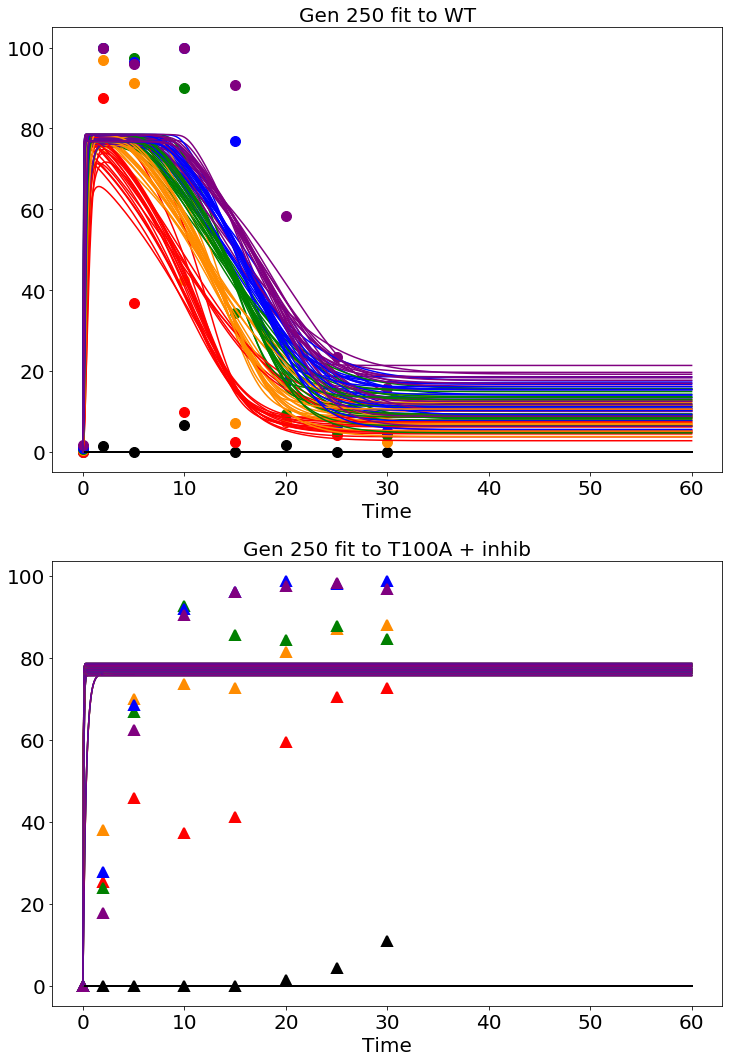

In [182]:
plt_param_behaviors(mapk_wt_data, mapk_t100a_data, 250, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time)

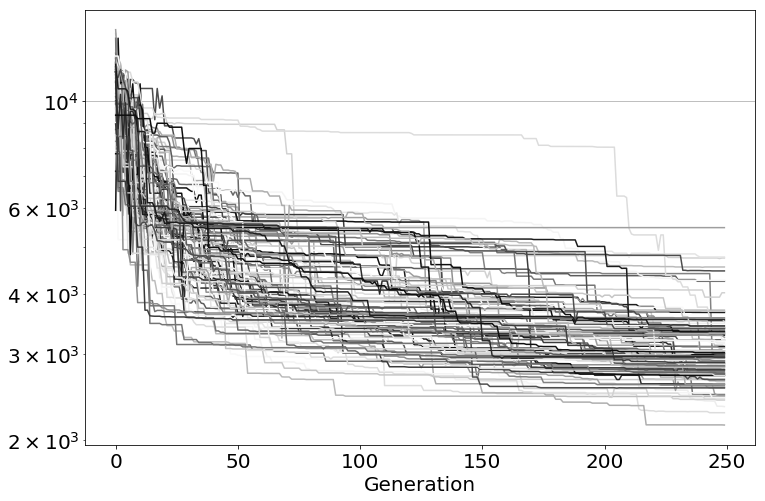

In [245]:
plt_mses_gen(250,mse)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


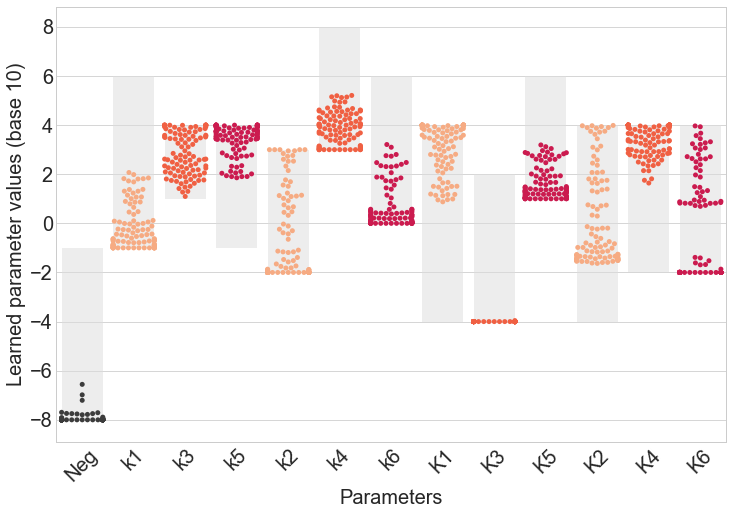

In [171]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

rocket = sns.color_palette("rocket", 5)#[::-1][:4]
rocket = rocket.as_hex()
colors = ['#3c3c3c'] + rocket[::-1][:3] + rocket[::-1][:3]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M)

#### Testing

In [ ]:
for idx in idx_top[:1]:
    i = []
    i = params_from_file[idx][gen].copy()
    print(i)
    i[0] = 0.00000001
    i[1] = 1
    i[2] = 1000
    i[3] = 100000
    print(i)
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment(initals, params_c, i, time)
        active = data[:,2]/params_constants[2]*100
        if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
            plt.plot(time, active, color=color_palette[idx])
        else:
            unstable += 1
# ax1.set_ylim(0, 100)
plt.ylim(0,100)

In [ ]:
plt.hist(last_mses,bins=15,color='#1f77b4')

## A1

### Functions

In [187]:
def b3_a1_0D(initals,t,params_constants,params):
    MAP3K, MAP2K, MAPK = initals
    MAP3K_t, MAP2K_t, MAPK_t, fb, s = params_constants
    beta_3, alpha_1, k1, k3, k5, k2, k4, k6, K_1, K_3, K_5, K_2, K_4, K_6 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    # X_I = X_t-X
    # Y_I = Y_t-Y

    dMAP3K = (s/(1+MAPK/beta_3)**fb) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K+alpha_1*MAPK)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    # dX = ((k7*MAPK*X_I) / (K_7+X_I)) - (k8*X/(K_8+X))
    # dY = ((k9*X*Y_I) / (K_9+Y_I)) - (k10*Y/(K_10+Y))

    return dMAP3K, dMAP2K, dMAPK

def simulate_wt_experiment(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_a1_0D, inits, time, args=(params_constants, learned_params))

    return odes

def simulate_t100a_experiment(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params
    MAP3K_t, MAP2K_t, MAPK_t, fb, s = params_constants
    params_constants = MAP3K_t, MAP2K_t, MAPK_t, 0, s

    beta_3, alpha_1, k1, k3, k5, k2, k4, k6, K_1, K_3, K_5, K_2, K_4, K_6 = learned_params
    learned_params = beta_3, 0, k1, k3, k5, k2, k4, k6, K_1, K_3, K_5, K_2, K_4, K_6

    #solve odes:
    odes = odeint(b3_a1_0D, inits, time, args=(params_constants, learned_params))

    return odes

### Inputs

In [188]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/Optimized_Fits/0D/181015_b3_a1_0D/'

gen = 500
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
# X = 0

MAP3K_t = molarity_conversion(1170)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
# X_t=1

s = [0, 150000, 250000, 350000, 450000, 550000]


labelnames = ['- Signal','+ MAPK',
              'k1', 'k3', 'k5', 
              'k2', 'k4', 'k6',
              'K1', 'K3', 'K5',
              'K2', 'K4', 'K6'
                ]

minimums = [-8, -2,
    -2, -2, -1,
    -3, -1,  0,
    -4, -4, -4,
    -6, -4, -4 ]

maximums = [ 0, 4,
    4, 6, 4,
    4, 6, 6,
    4, 4, 5,
    4, 4, 4 ]

diff = np.asarray(maximums)-np.asarray(minimums)

fb = 1
# t100a_fb = 0

initals = [MAP3K, MAP2K, MAPK]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, fb, s] 

# Parameter's being learned
# params = beta_0, alpha_2,    k1, k3, k5, k7,    k2, k4, k6, k8,    kn, kc,    K_1, K_3, K_5, K_7,    K_2, K_4, K_6, K_8
    
dt = 0.1
steps = 600
time = np.linspace(0,dt*steps,steps)

### Gather simulated data

In [189]:
idx_top, top_params, top, plt_top, new_params, params_from_file, mse, last_mses_a1_0D = gather_simulated_data(folder, gen, runs)
df_top_params = pd.DataFrame(top_params)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 18827.2624595
Mean MSE of top 5%: 19647.896168


### Plot

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


# of unstable WT experiments: 1 of 120
# of unstable T100A experiments: 0 of 120


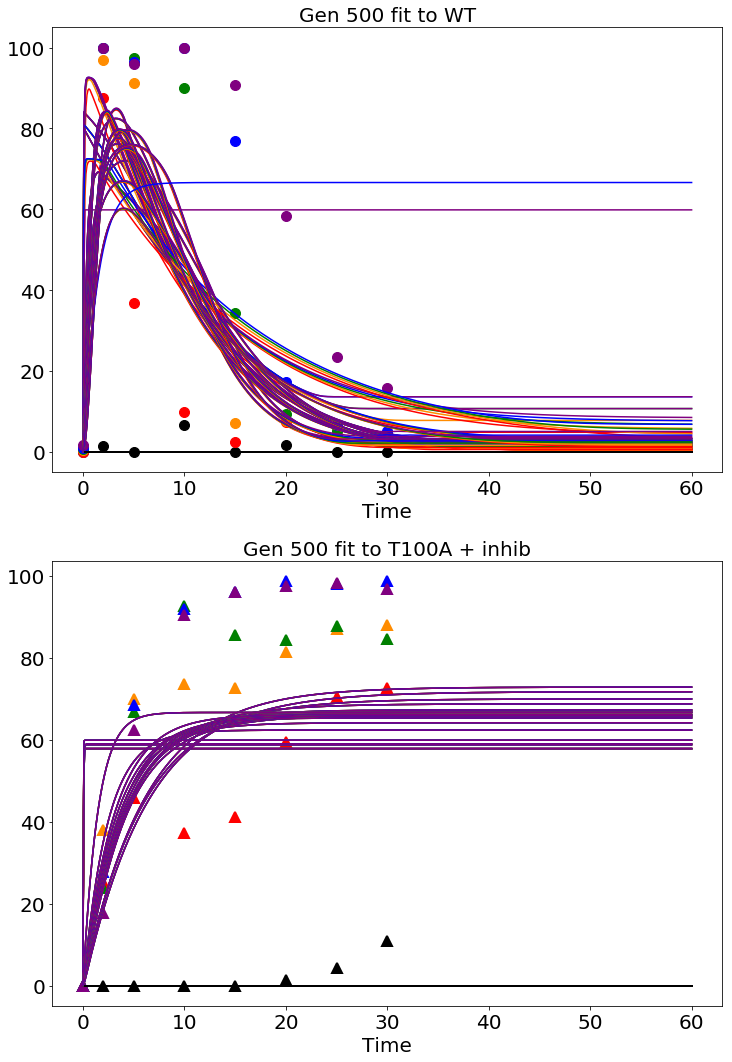

In [190]:
plt_param_behaviors(mapk_wt_data, mapk_t100a_data, gen, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time)

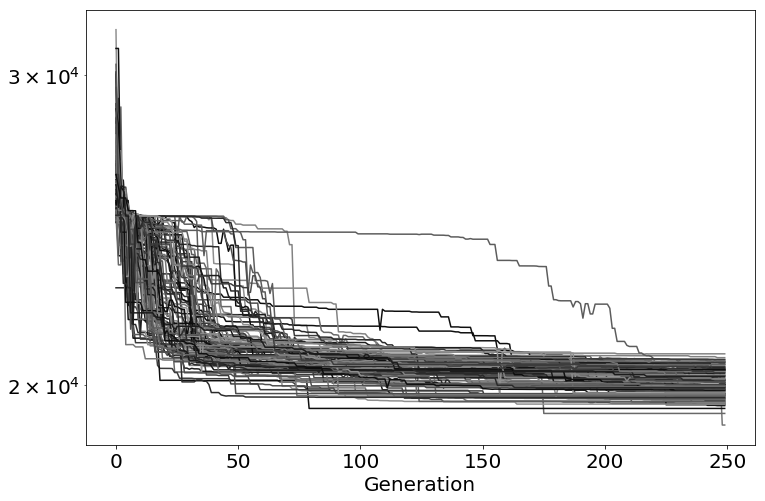

In [191]:
plt_mses_gen(250,mse)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


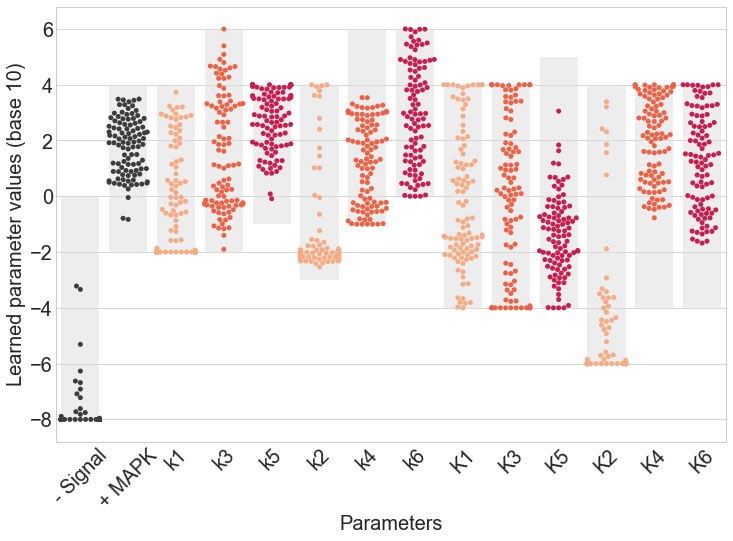

In [192]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] + rocket[::-1][:3] + rocket[::-1][:3]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M)

## A2

### Functions

In [193]:
def b3_a2_0D(initals,t,params_constants,params):
    MAP3K, MAP2K, MAPK = initals
    MAP3K_t, MAP2K_t, MAPK_t, fb, s = params_constants
    beta_3, alpha_2, k1, k3, k5, k2, k4, k6, K_1, K_3, K_5, K_2, K_4, K_6 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    # X_I = X_t-X
    # Y_I = Y_t-Y

    dMAP3K = (s/(1+MAPK/beta_3)**fb) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K+alpha_2*MAPK)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    # dX = ((k7*MAPK*X_I) / (K_7+X_I)) - (k8*X/(K_8+X))
    # dY = ((k9*X*Y_I) / (K_9+Y_I)) - (k10*Y/(K_10+Y))

    return dMAP3K, dMAP2K, dMAPK

def simulate_wt_experiment(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_a2_0D, inits, time, args=(params_constants, learned_params))

    return odes

def simulate_t100a_experiment(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params
    MAP3K_t, MAP2K_t, MAPK_t, fb, s = params_constants
    params_constants = MAP3K_t, MAP2K_t, MAPK_t, 0, s

    beta_3, alpha_2, k1, k3, k5, k2, k4, k6, K_1, K_3, K_5, K_2, K_4, K_6 = learned_params
    learned_params = beta_3, 0, k1, k3, k5, k2, k4, k6, K_1, K_3, K_5, K_2, K_4, K_6

    #solve odes:
    odes = odeint(b3_a2_0D, inits, time, args=(params_constants, learned_params))

    return odes

### Inputs

In [200]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/Optimized_Fits/0D/181015_b3_a2_0D/'

gen = 500
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
# X = 0

MAP3K_t = molarity_conversion(1170)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
# X_t=1

s = [0, 150000, 250000, 350000, 450000, 550000]


labelnames = ['-fb','+2K',
              'k1', 'k3', 'k5', 
              'k2', 'k4', 'k6',
              'K1', 'K3', 'K5',
              'K2', 'K4', 'K6'
                ]

minimums = [-8, -8,
    -2,  1, -1,
    -3,  1,  0,
    -4, -4,  1,
    -4, -4, -4 ]

maximums = [ 0, -1,
    4, 6, 4,
    3, 6, 4,
    4, 3, 6,
    4, 4, 4 ]

diff = np.asarray(maximums)-np.asarray(minimums)

fb = 1
# t100a_fb = 0

initals = [MAP3K, MAP2K, MAPK]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, fb, s] 

# Parameter's being learned
# params = beta_0, alpha_2,    k1, k3, k5, k7,    k2, k4, k6, k8,    kn, kc,    K_1, K_3, K_5, K_7,    K_2, K_4, K_6, K_8
    
dt = 0.1
steps = 600
time = np.linspace(0,dt*steps,steps)

### Gather simulated data

In [195]:
idx_top, top_params, top, plt_top, new_params, params_from_file, mse, last_mses_a2_0D = gather_simulated_data(folder, gen, runs)
df_top_params = pd.DataFrame(top_params)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 20069.0244883
Mean MSE of top 5%: 20394.1940571


### Plot

# of unstable WT experiments: 0 of 120
# of unstable T100A experiments: 0 of 120


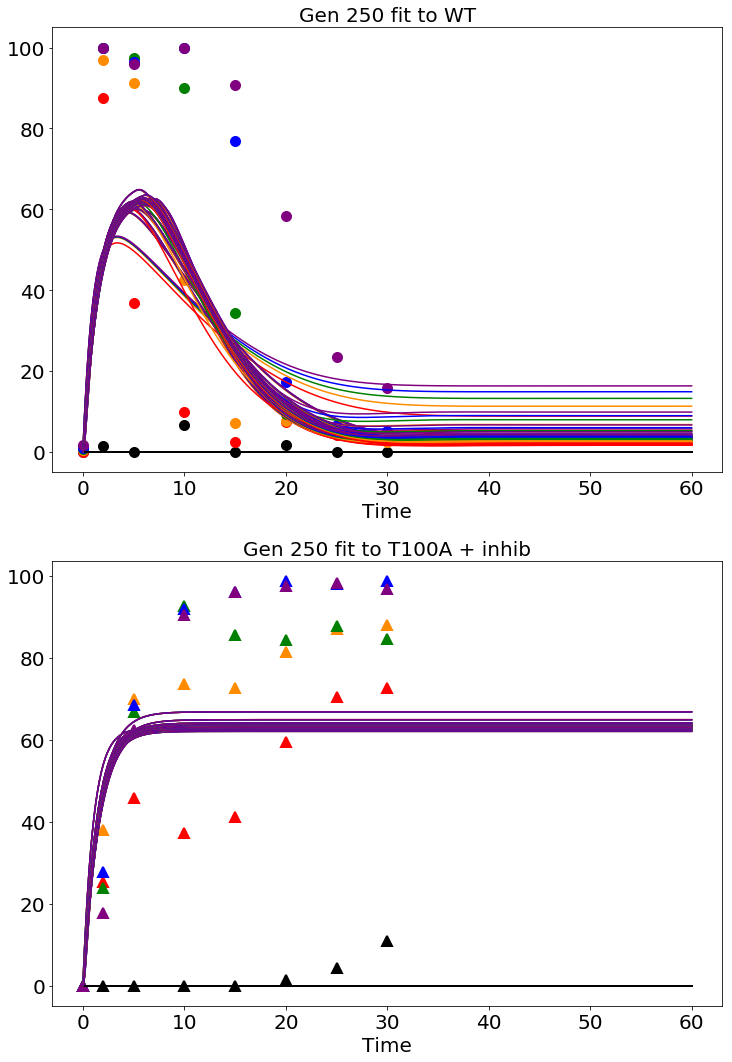

In [199]:
plt_param_behaviors(mapk_wt_data, mapk_t100a_data, 250, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time)

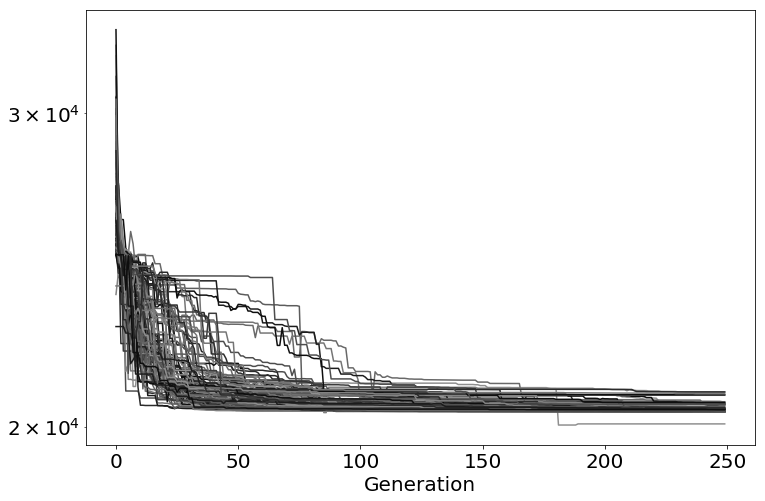

In [201]:
plt_mses(250,mse)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


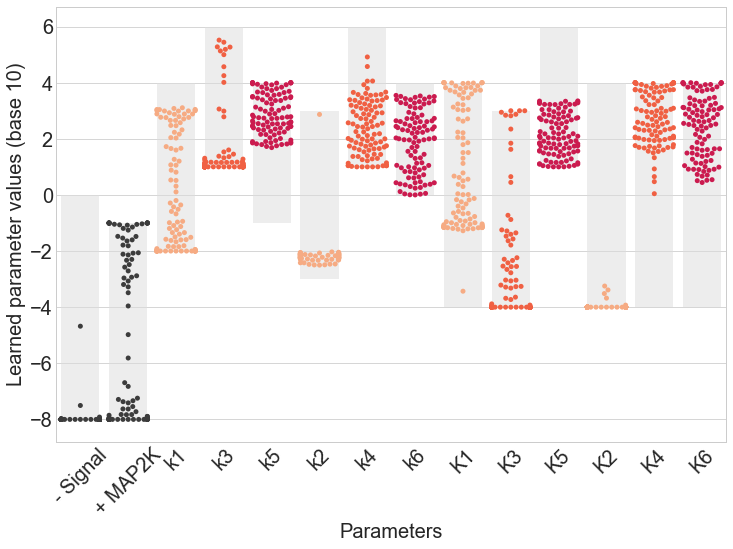

In [197]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] + rocket[::-1][:3] + rocket[::-1][:3]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M)

## A3

### Functions

In [306]:
def b3_a3_0D(initals,t,params_constants,params):
    MAP3K, MAP2K, MAPK = initals
    MAP3K_t, MAP2K_t, MAPK_t, fb, s = params_constants
    beta_3, alpha_3, k1, k3, k5, k2, k4, k6, K_1, K_3, K_5, K_2, K_4, K_6 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    # X_I = X_t-X
    # Y_I = Y_t-Y

    dMAP3K = (s/(1+MAPK/beta_3)**fb) * (((k1+alpha_3*MAPK)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    # dX = ((k7*MAPK*X_I) / (K_7+X_I)) - (k8*X/(K_8+X))
    # dY = ((k9*X*Y_I) / (K_9+Y_I)) - (k10*Y/(K_10+Y))

    return dMAP3K, dMAP2K, dMAPK

def simulate_wt_experiment(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_a3_0D, inits, time, args=(params_constants, learned_params))

    return odes

def simulate_t100a_experiment(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params
    MAP3K_t, MAP2K_t, MAPK_t, fb, s = params_constants
    params_constants = MAP3K_t, MAP2K_t, MAPK_t, 0, s

    beta_3, alpha_3, k1, k3, k5, k2, k4, k6, K_1, K_3, K_5, K_2, K_4, K_6 = learned_params
    learned_params = beta_3, 0, k1, k3, k5, k2, k4, k6, K_1, K_3, K_5, K_2, K_4, K_6

    #solve odes:
    odes = odeint(b3_a3_0D, inits, time, args=(params_constants, learned_params))

    return odes

### Inputs

In [307]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/Optimized_Fits/0D/181015_b3_a3_0D/'

gen = 500
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
# X = 0

MAP3K_t = molarity_conversion(1170)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
# X_t=1

s = [0, 150000, 250000, 350000, 450000, 550000]


labelnames = ['-fb','+3K',
              'k1', 'k3', 'k5', 
              'k2', 'k4', 'k6',
              'K1', 'K3', 'K5',
              'K2', 'K4', 'K6'
                ]

minimums = [-8, -2,
    -1, -4, -1,
    -4, -4, -2,
    -4, -4, -2,
    -4, -4, -4 ]

maximums = [ 1, 6,
    5, 4, 5,
    4, 4, 4,
    3, 4, 4,
    4, 4, 4 ]

diff = np.asarray(maximums)-np.asarray(minimums)

fb = 1
# t100a_fb = 0

initals = [MAP3K, MAP2K, MAPK]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, fb, s] 

# Parameter's being learned
# params = beta_0, alpha_2,    k1, k3, k5, k7,    k2, k4, k6, k8,    kn, kc,    K_1, K_3, K_5, K_7,    K_2, K_4, K_6, K_8
    
dt = 0.1
steps = 600
time = np.linspace(0,dt*steps,steps)

### Gather simulated data

In [215]:
idx_top, top_params, top, plt_top, new_params, params_from_file, mse, last_mses_a3_0D = gather_simulated_data(folder, gen, runs)
df_top_params = pd.DataFrame(top_params)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 19727.6226705
Mean MSE of top 5%: 20365.7272867


### Plot

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


# of unstable WT experiments: 0 of 120
# of unstable T100A experiments: 0 of 120


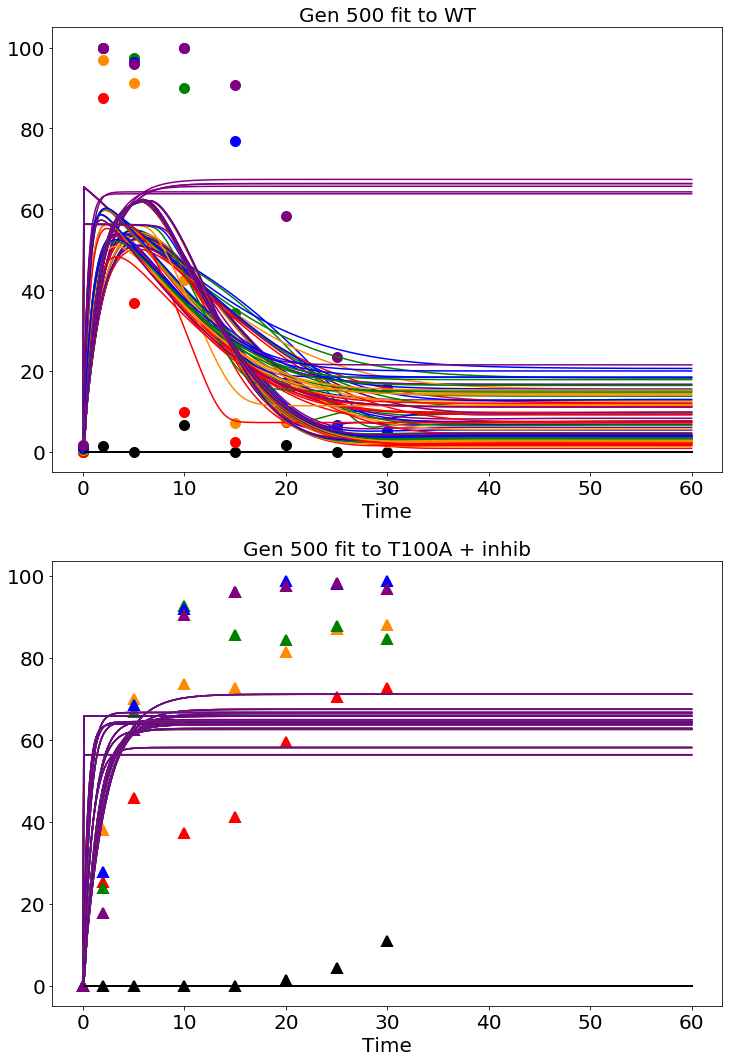

In [216]:
plt_param_behaviors(mapk_wt_data, mapk_t100a_data, gen, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time)

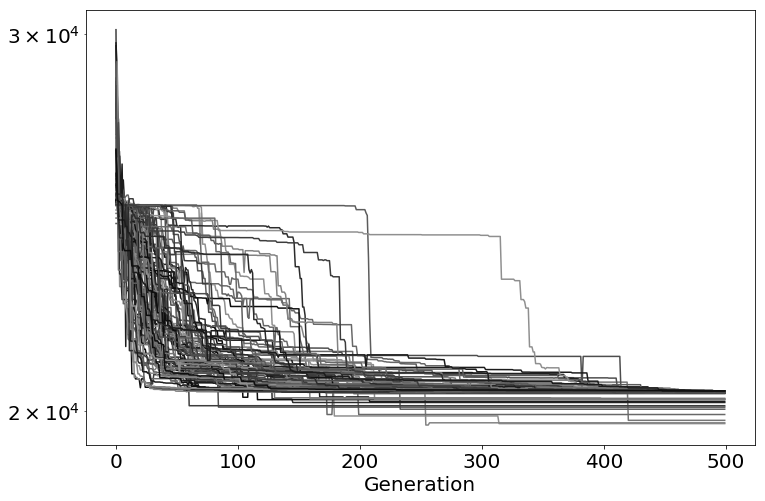

In [211]:
plt_mses_gen(500,mse)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


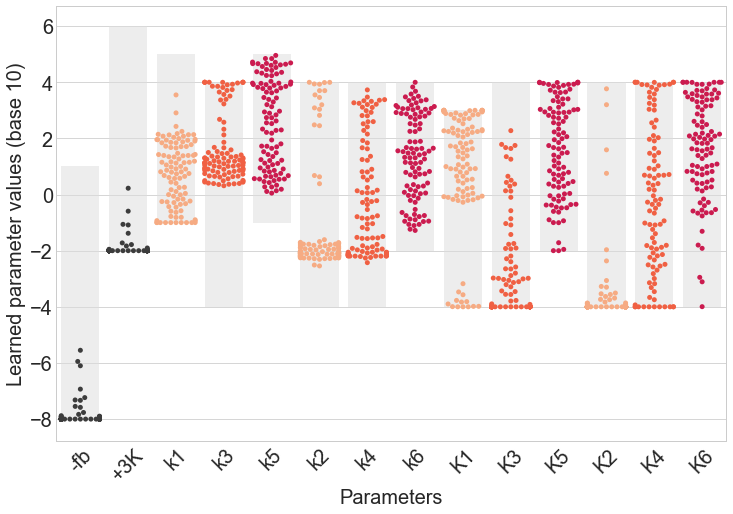

In [212]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

rocket = sns.color_palette("rocket", 5)#[::-1][:4]
rocket = rocket.as_hex()
colors = ['#3c3c3c','#3c3c3c'] + rocket[::-1][:3] + rocket[::-1][:3]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M)

# One step delay

## AN

### Functions

In [96]:
def b3_aN_1D_X(initals,t,params_constants,params):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t, X_t, s = params_constants
    beta_3, k1, k3, k5, k7, k2, k4, k6, k8, K_1, K_3, K_5, K_7, K_2, K_4, K_6, K_8 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    X_I = X_t-X
    # Y_I = Y_t-Y

    dMAP3K = (s/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = ((k7*MAPK*X_I) / (K_7+X_I)) - (k8*X/(K_8+X))
    # dY = ((k9*X*Y_I) / (K_9+Y_I)) - (k10*Y/(K_10+Y))

    return dMAP3K, dMAP2K, dMAPK, dX

def simulate_wt_experiment(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_aN_1D_X, inits, time, args=(params_constants, learned_params))

    return odes

def simulate_t100a_experiment(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params
    beta_3, k1, k3, k5, k7, k2, k4, k6, k8, K_1, K_3, K_5, K_7, K_2, K_4, K_6, K_8  = learned_params
    learned_params = beta_3, k1, k3, k5, 0, k2, k4, k6, k8, K_1, K_3, K_5, K_7, K_2, K_4, K_6, K_8

    #solve odes:
    odes = odeint(b3_aN_1D_X, inits, time, args=(params_constants, learned_params))

    return odes

### Inputs

In [97]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/Optimized_Fits/1D/181013_b3_aN_1D'

gen = 500
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0

MAP3K_t = molarity_conversion(1170)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
X_t = 1

s = [0, 150000, 250000, 350000, 450000, 550000]


labelnames = ['- Signal',
              'k1', 'k3', 'k5', 'k7',
              'k2', 'k4', 'k6', 'K7',
              'K1', 'K3', 'K5', 'k8',
              'K2', 'K4', 'K6', 'K8'
                ]

minimums = [-8,
    -6,  0,  0,  2,
    -4, -4, -3, -2,
    -4, -6, -6, -4,
    -4, -4, -3, -8]

maximums = [ -1,
    4, 6, 6, 8,
    4, 4, 4, 2,
    4, 2, 3, 4,
    4, 4, 4, 0]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initals = [MAP3K, MAP2K, MAPK, X]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, X_t, s] 
    
dt = 0.1
steps = 600
time = np.linspace(0,dt*steps,steps)

### Gather simulated data

In [98]:
idx_top, top_params, top, plt_top, new_params, params_from_file, mse, last_mses_an_1D = gather_simulated_data(folder, gen, runs)
df_top_params = pd.DataFrame(top_params)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 2749.90933692
Mean MSE of top 5%: 3147.75319849


### Plot

In [ ]:
plt_param_behaviors(mapk_wt_data, mapk_t100a_data, gen, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time)

In [ ]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#ee9537',
          '#e84728','#1f77b4','#94ddaa','#985f85',
          '#e84728','#1f77b4','#94ddaa','#985f85',
          '#e84728','#1f77b4','#94ddaa','#985f85',
          '#e84728','#1f77b4','#94ddaa','#985f85']

plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M)

## A1

### Functions

In [247]:
def b3_a1_1D_X(initals,t,params_constants,params):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t, X_t, s = params_constants
    beta_3, alpha_1, k1, k3, k5, k7, k2, k4, k6, k8, K_1, K_3, K_5, K_7, K_2, K_4, K_6, K_8 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    X_I = X_t-X
    # Y_I = Y_t-Y

    dMAP3K = (s/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K+alpha_1*MAPK)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = ((k7*MAPK*X_I) / (K_7+X_I)) - (k8*X/(K_8+X))
    # dY = ((k9*X*Y_I) / (K_9+Y_I)) - (k10*Y/(K_10+Y))

    return dMAP3K, dMAP2K, dMAPK, dX

def simulate_wt_experiment(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_a1_1D_X, inits, time, args=(params_constants, learned_params))

    return odes

def simulate_t100a_experiment(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params
    beta_3, alpha_1, k1, k3, k5, k7, k2, k4, k6, k8, K_1, K_3, K_5, K_7, K_2, K_4, K_6, K_8  = learned_params
    learned_params = beta_3, 0, k1, k3, k5, 0, k2, k4, k6, k8, K_1, K_3, K_5, K_7, K_2, K_4, K_6, K_8

    #solve odes:
    odes = odeint(b3_a1_1D_X, inits, time, args=(params_constants, learned_params))

    return odes

### Inputs

In [253]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/Optimized_Fits/1D/181015_b3_a1_1D'

gen = 500
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0

MAP3K_t = molarity_conversion(1170)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
X_t = 1

s = [0, 150000, 250000, 350000, 450000, 550000]


labelnames = ['-fb', '+K',
              'k1', 'k3', 'k5', 'k7',
              'k2', 'k4', 'k6', 'k8',
              'K1', 'K3', 'K5', 'K7',
              'K2', 'K4', 'K6', 'K8'
                ]

minimums = [-8, -1,
    -4, -3, -1, -2,
    -2, -2,  0, -2,
    -4, -4, -2, -2,
    -4, -4, -4, -2]

maximums = [ 1, 4,
    4, 4, 6, 2,
    6, 6, 6, 2,
    4, 4, 5, 2,
    4, 4, 4, 2]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initals = [MAP3K, MAP2K, MAPK, X]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, X_t, s] 
    
dt = 0.1
steps = 600
time = np.linspace(0,dt*steps,steps)

### Gather simulated data

In [254]:
idx_top, top_params, top, plt_top, new_params, params_from_file, mse, last_mses_a1_1D = gather_simulated_data(folder, gen, runs)
df_top_params = pd.DataFrame(top_params)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 766.375868164
Mean MSE of top 5%: 1816.09236535


### Plot

# of unstable WT experiments: 0 of 120
# of unstable T100A experiments: 0 of 120


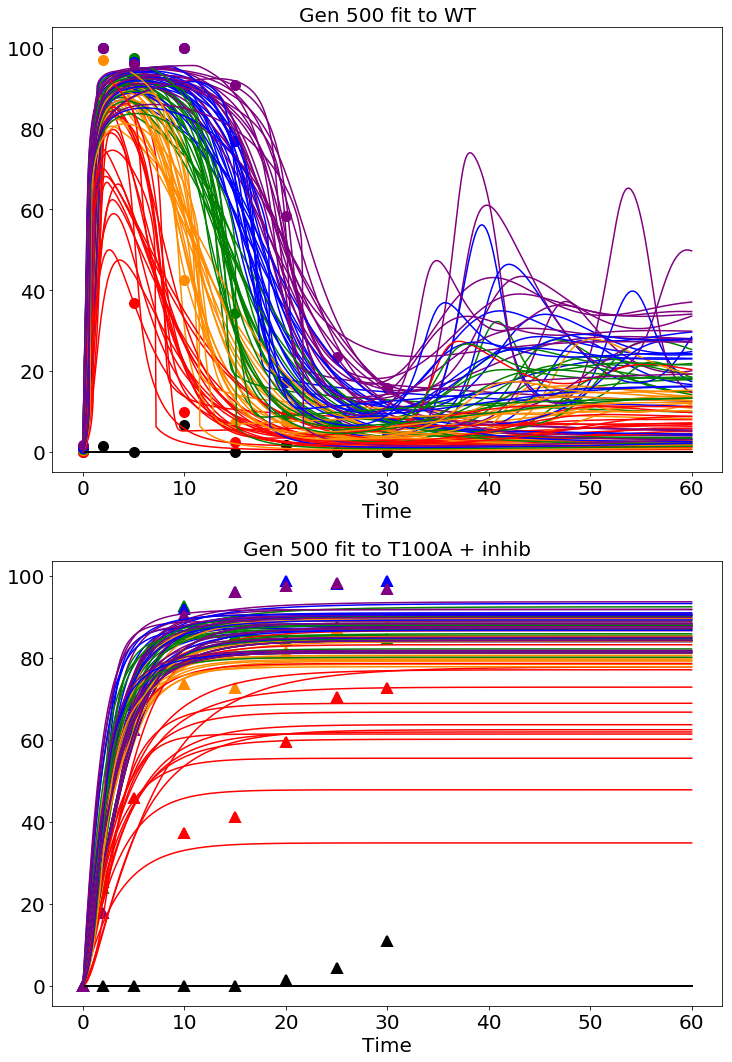

In [255]:
plt_param_behaviors(mapk_wt_data, mapk_t100a_data, gen, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time)

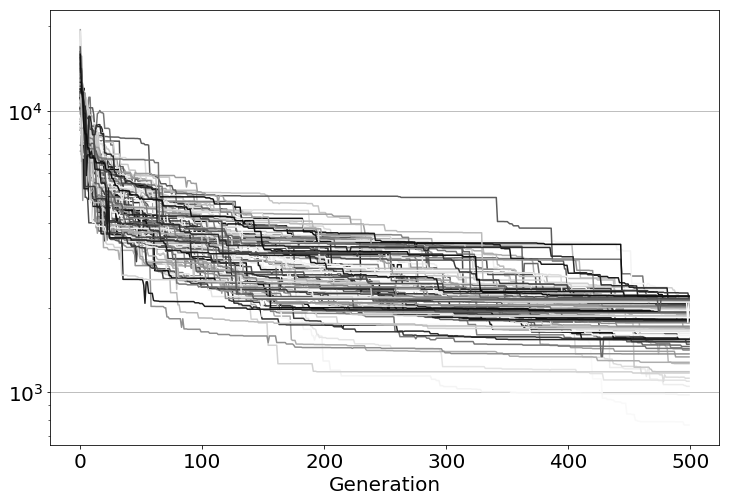

In [251]:
plt_mses_gen(500,mse)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


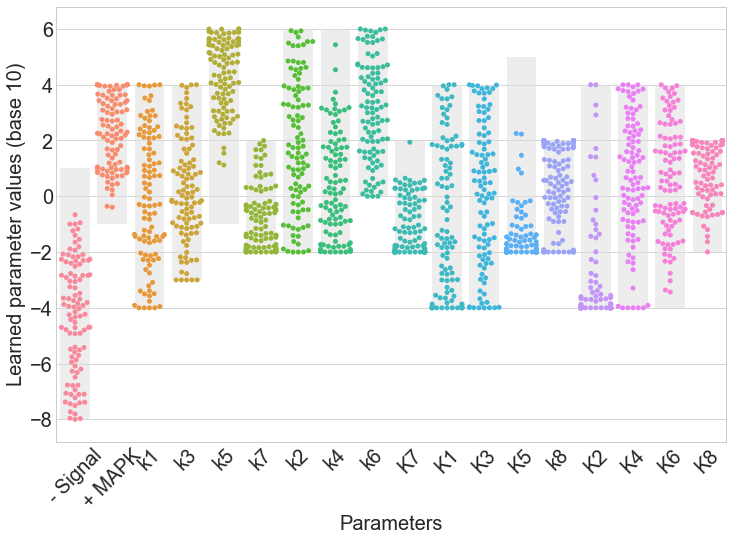

In [252]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] + rocket[::-1][:3] + rocket[::-1][:3]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M)

In [ ]:
plt.hist(last_mses,bins=15,color='#1f77b4')

## A2

### Functions

In [299]:
def b3_a2_1D_X(initals,t,params_constants,params):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t, X_t, s = params_constants
    beta_3, alpha_2, k1, k3, k5, k7, k2, k4, k6, k8, K_1, K_3, K_5, K_7, K_2, K_4, K_6, K_8 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    X_I = X_t-X
    # Y_I = Y_t-Y

    dMAP3K = (s/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K+alpha_2*MAPK)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = ((k7*MAPK*X_I) / (K_7+X_I)) - (k8*X/(K_8+X))
    # dY = ((k9*X*Y_I) / (K_9+Y_I)) - (k10*Y/(K_10+Y))

    return dMAP3K, dMAP2K, dMAPK, dX

def simulate_wt_experiment(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_a2_1D_X, inits, time, args=(params_constants, learned_params))

    return odes

def simulate_t100a_experiment(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params
    beta_3, alpha_2, k1, k3, k5, k7, k2, k4, k6, k8, K_1, K_3, K_5, K_7, K_2, K_4, K_6, K_8  = learned_params
    learned_params = beta_3, 0, k1, k3, k5, 0, k2, k4, k6, k8, K_1, K_3, K_5, K_7, K_2, K_4, K_6, K_8

    #solve odes:
    odes = odeint(b3_a2_1D_X, inits, time, args=(params_constants, learned_params))

    return odes

### Inputs

In [285]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/Optimized_Fits/1D/181015_b3_a2_1D'

gen = 500
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0

MAP3K_t = molarity_conversion(1170)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
X_t = 1

s = [0, 150000, 250000, 350000, 450000, 550000]


labelnames = ['-fb', '+2K',
              'k1', 'k3', 'k5', 'k7',
              'k2', 'k4', 'k6', 'k8',
              'K1', 'K3', 'K5', 'K7',
              'K2', 'K4', 'K6', 'K8'
                ]

minimums = [-6, -4,
    -4, -1, -1, -2,
    -2, -1,  0, -2,
    -4, -4, -2, -2,
    -4, -4, -4, -2]

maximums = [ 1, 3,
    4, 6, 6, 2,
    6, 6, 6, 2,
    4, 4, 6, 2,
    3, 4, 4, 2]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initals = [MAP3K, MAP2K, MAPK, X]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, X_t, s] 
    
dt = 0.1
steps = 600
time = np.linspace(0,dt*steps,steps)

### Gather simulated data

In [286]:
idx_top, top_params, top, plt_top, new_params, params_from_file, mse, last_mses_a2_1D = gather_simulated_data(folder, gen, runs)
df_top_params = pd.DataFrame(top_params)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 620.065430819
Mean MSE of top 5%: 2505.32525174


### Plot

# of unstable WT experiments: 0 of 6
# of unstable T100A experiments: 0 of 6


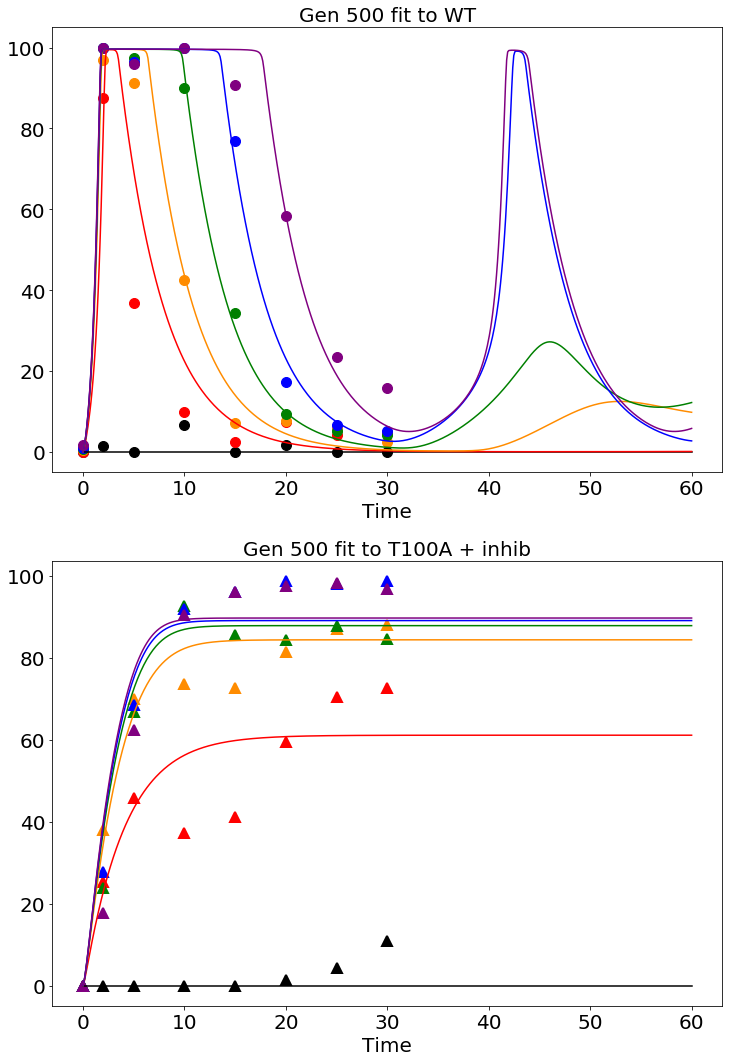

In [281]:
plt_param_behaviors(mapk_wt_data, mapk_t100a_data, gen, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time)

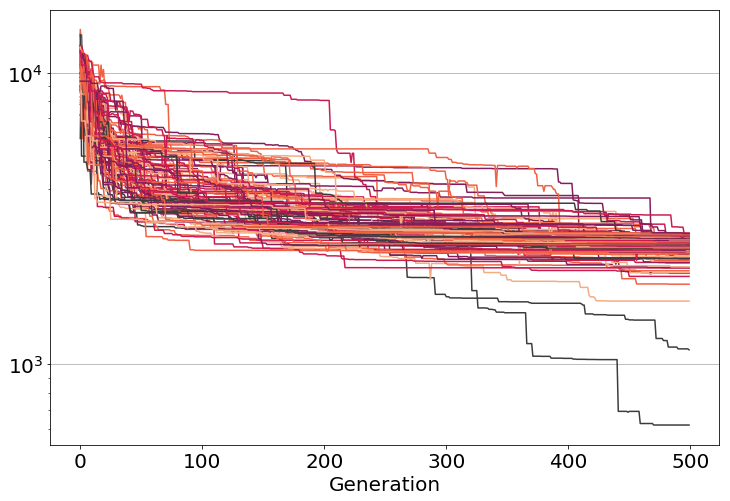

In [282]:
plt_mses_gen(gen,mse)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


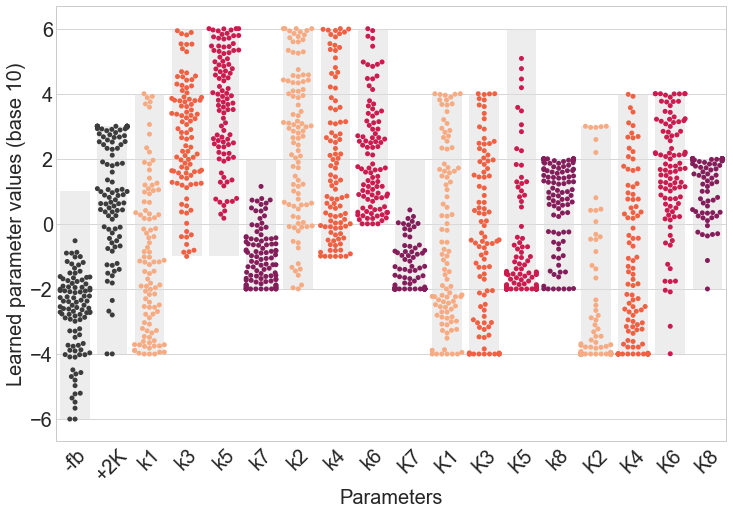

In [283]:
# positive 3db7d6
# negative ee9537
# hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] + rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:4]+ rocket[::-1][:4]

plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M)

In [ ]:
plt.hist(last_mses,bins=15,color='#1f77b4')

## A3

### Functions

In [300]:
def b3_a3_1D_X(initals,t,params_constants,params):
    MAP3K, MAP2K, MAPK, X = initals
    MAP3K_t, MAP2K_t, MAPK_t, X_t, s = params_constants
    beta_3, alpha_3, k1, k3, k5, k7, k2, k4, k6, k8, K_1, K_3, K_5, K_7, K_2, K_4, K_6, K_8 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    X_I = X_t-X
    # Y_I = Y_t-Y

    dMAP3K = (s/(1+X/beta_3)) * (((k1+alpha_3*MAPK)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = ((k7*MAPK*X_I) / (K_7+X_I)) - (k8*X/(K_8+X))
    # dY = ((k9*X*Y_I) / (K_9+Y_I)) - (k10*Y/(K_10+Y))

    return dMAP3K, dMAP2K, dMAPK, dX

def simulate_wt_experiment(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_a3_1D_X, inits, time, args=(params_constants, learned_params))

    return odes

def simulate_t100a_experiment(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params
    beta_3, alpha_3, k1, k3, k5, k7, k2, k4, k6, k8, K_1, K_3, K_5, K_7, K_2, K_4, K_6, K_8  = learned_params
    learned_params = beta_3, 0, k1, k3, k5, 0, k2, k4, k6, k8, K_1, K_3, K_5, K_7, K_2, K_4, K_6, K_8

    #solve odes:
    odes = odeint(b3_a3_1D_X, inits, time, args=(params_constants, learned_params))

    return odes

### Inputs

In [301]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/Optimized_Fits/1D/181015_b3_a3_1D'

gen = 500
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0

MAP3K_t = molarity_conversion(1170)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
X_t = 1

s = [0, 150000, 250000, 350000, 450000, 550000]


labelnames = ['-fb', '+fb 3K',
              'k1', 'k3', 'k5', 'k7',
              'k2', 'k4', 'k6', 'k8',
              'K1', 'K3', 'K5', 'K7',
              'K2', 'K4', 'K6', 'K8'
                ]

minimums = [-8, -4,
    -6, -2,  0, -2,
    -1, -2,  0, -2,
    -4, -4, -1, -2,
    -4, -3, -1, -2]

maximums = [ 0, 4,
    2, 6, 6, 2,
    6, 6, 6, 2,
    4, 4, 6, 2,
    4, 4, 5, 2]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initals = [MAP3K, MAP2K, MAPK, X]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, X_t, s] 
    
dt = 0.1
steps = 600
time = np.linspace(0,dt*steps,steps)

### Gather simulated data

In [302]:
idx_top, top_params, top, plt_top, new_params, params_from_file, mse, last_mses_a3_1D = gather_simulated_data(folder, gen, runs)
df_top_params = pd.DataFrame(top_params)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 801.431748022
Mean MSE of top 5%: 1212.30352444


### Plot

# of unstable WT experiments: 0 of 120
# of unstable T100A experiments: 0 of 120


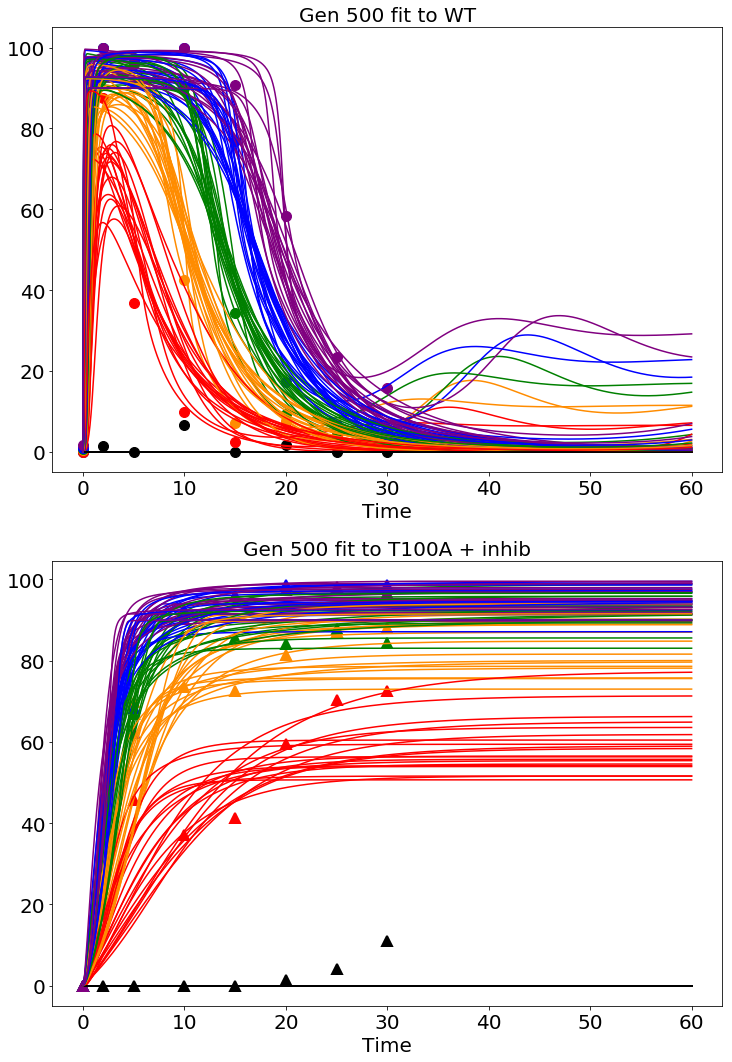

In [303]:
plt_param_behaviors(mapk_wt_data, mapk_t100a_data, gen, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time)

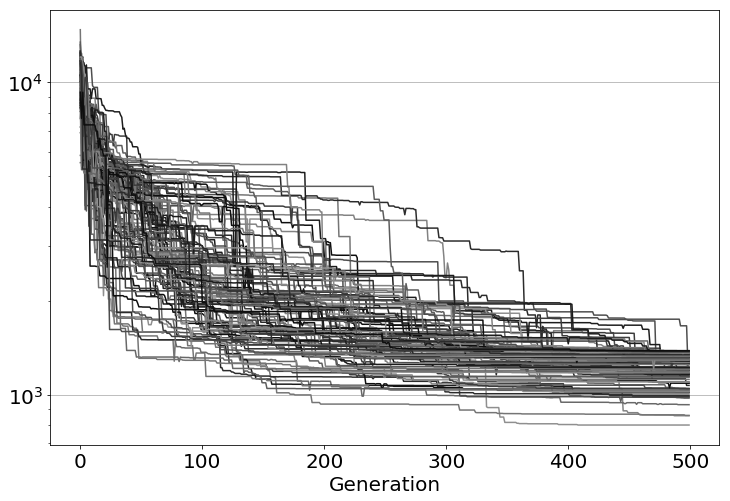

In [304]:
plt_mses_gen(gen,mse)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


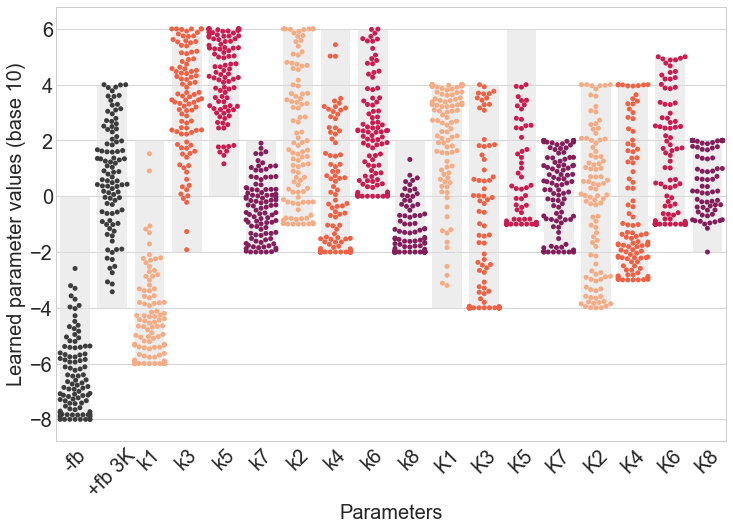

In [305]:
# positive 3db7d6
# negative ee9537
# hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] + rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:4]+ rocket[::-1][:4]

plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M)

### Lab meeting

#### individ

In [ ]:
colors = ['#000000','#ff0000','#FF8C00','#008000','#0000FF','#800080']

color_palette = sns.color_palette(colors)
plt.rcParams['figure.figsize'] = [12.0, 8.0]

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
for i, params in enumerate(top_params[17:18]):#17:18
#     beta_1, beta_2, alpha, k1, k2, k3, k4, k5, k6, k7, k8, K_1, K_2, K_3, K_4, K_5, K_6, K_7, K_8, kn, kc = params
#     params = beta_1, beta_2, 0, k1, k2, k3, k4, k5, k6, k7, k8, K_1, K_2, K_3, K_4, K_5, K_6, K_7, K_8, 0, kc
    #plot real data:
    for idx, (wt_data,t100a_data) in enumerate(zip(mapk_wt_data, mapk_t100a_data)):
        ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
    for idx, signal in enumerate(s):
        data = odeint(b3_a3_1D_X, initals, time, args=(params_constants[:-1]+[signal], params))
        active = data[:,2]/params_constants[2]*100
        ax1.plot(time, active, label=str(int(signal/1000))+'mM KCl', color=color_palette[idx])

#     plt.title(f'Param set {i}')
    ax1.set_title('One simulation fit to WT data')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('% ppHog1')
#     plt.show()
    ax1.set_xlim(0,32)
    ax1.set_ylim(0,105)
    ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/wt_individ.png",dpi=150, bbox_inches='tight')
    plt.clf()


In [ ]:
fig, (ax2) = plt.subplots(nrows=1, ncols=1, figsize=(12,8))

for i, params in enumerate(top_params[17:18]):#17:18
    for idx, (wt_data,t100a_data) in enumerate(zip(mapk_wt_data, mapk_t100a_data)):
        plt.plot(mapk_time, t100a_data, '^', mew=2, markersize=10, color=color_palette[idx])
    for idx, signal in enumerate(s):
#         plt.plot(time, data[:,4], dashes=[2, 2], label=str(signal)+' X')
        data = simulate_t100a_experiment(initals, params_constants[:-1]+[signal], params, time)
        active = data[:,2]/params_constants[2]*100
        plt.plot(time, active, label=str(int(signal/1000))+'mM KCl', dashes= [4,2], color=color_palette[idx])
#         plt.plot(time, data[:,3], label=str(signal)+' MAPKn')
#     plt.title(f'Param set {i}')
    ax2.set_title('One simulation fit to Hog1 T100A + Inhib data')
    ax2.set_xlim(0,32)
    ax2.set_ylim(0,105)
    ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('% ppHog1')
#     plt.ylim(0,100)
#     plt.show()
    plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/t100a_individ.png",dpi=150, bbox_inches='tight')

In [ ]:
fig, (ax3) = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
for i in range(0,gen+1,5):
    #plot3 
    # sns.color_palette(palette_husl)
#     pal = sns.color_palette("Greys", 20)[10:]
    ax3.set_xlabel('Generation', fontsize=20)
    # ax2.set_ylabel('Sum of MSE', fontsize=20)
    # ax2.set_xlim([0,gen])
    # ax2.set_ylim([10**3,10**5])
    pal = sns.set_palette(pal)
    for idx in idx_top[17:18]:
        ax3.semilogy([x for x in range(i)], mse[idx][:i], color='black')
    #     ax3.plot([x for x in range(gen)], mse[idx][:gen])
    ax3.yaxis.grid(True)
    ax3.set_xlim(0,505)
    ax3.set_ylim(800,20000)
    # locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=10)
    # ax3.yaxis.set_minor_locator(locmin)
    # ax3.yaxis.set_minor_formatter(mticker.NullFormatter())
#     plt.show()
#     plt.ioff()
plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/mse_individ.png",dpi=150)
plt.show()

In [ ]:
labelnames = ['-fb', '+fb',
              'k1', 'k3', 'k5', 'k7',
              'k2', 'k4', 'k6', 'k8',
              'K1', 'K3', 'K5', 'K7',
              'K2', 'K4', 'K6', 'K8'
                ]

rocket = sns.color_palette("rocket", 5)#[::-1][:4]
rocket = rocket.as_hex()
rocket[::-1][:4]*4
colors = ['#9e9e9e','#3c3c3c'] + rocket[::-1][:4]*4
param_col = sns.set_palette(colors)
all_top_params = [params_from_file[x] for x in idx_top]
    
# for i in range(0,gen+1,5):
plt.clf()
top_params = [all_top_params[x][gen] for x in range(100)]
df_top_params = pd.DataFrame(top_params[17:18])
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

fig, (ax4) = plt.subplots(nrows=1, ncols=1, figsize=(12,8))


ax4.bar(range(0,len(labelnames)),height=diff,bottom=minimums,align='center',tick_label=labelnames, color='#DCDCDC',alpha = 0.5)
ax4 = sns.swarmplot(x='param',y='vals', data = df_top_params_log_M, color=param_col, size=10)
ax4.set_xticklabels(labelnames,rotation=45)
#     ax.set_yscale("log")
#     ax.set_ylim(0.00001,100000)
#     ax4.set_xticks(locs)
#     plt.xticklabels(labelnames, fontsize=18, rotation=90)
ax4.set_xlabel('Parameters', fontsize=20)
ax4.set_ylabel('Learned parameter values (base 10)', fontsize=20)
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax4.yaxis.grid(True)
# plt.show()
plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/param_individ.png",dpi=150)
#     plt.ioff()

#### gifs

In [ ]:
colors = ['#000000','#ff0000','#FF8C00','#008000','#0000FF','#800080']

pal = sns.color_palette(colors)
sns.palplot(pal)

In [ ]:
dt = 0.1
steps = 300
time = np.linspace(0,dt*steps,steps)

import warnings
warnings.filterwarnings(action='once')

for i in range(0,gen+1,5):
    plt.clf()


    # with sns.axes_style("whitegrid"):
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
    colors = ['#000000','#ff0000','#FF8C00','#008000','#0000FF','#800080']

    pal = sns.color_palette(colors)

    # plot 1
    title_text = 'Gen ' + str(i) + ' fit to WT'
    ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time', fontsize=20)
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20)
    # color_palette = sns.color_palette("rocket", 6)[::-1]


    # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    

    # plot evolutionary algorithm data on plots 1 and 2:
    # unstable_wt = 0
    # unstable_t100a = 0
    for idx in idx_top[:plt_top]:
        learned_params = params_from_file[idx][i]
        for idx, sig in enumerate(params_constants[-1]):
            params_c = params_constants[:-1]+[sig]
            data = simulate_wt_experiment(initals, params_c, learned_params, time)
            active = data[:,2]/params_constants[2]*100
            if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
                ax1.plot(time, active, color=pal[idx])
    #         else:
    #             unstable_wt += 1
    #             unstable_t100a += 1
    # print('# of unstable WT experiments: ' + str(unstable_wt) + ' of ' + str(plt_top*6))
    # print('# of unstable T100A experiments: ' + str(unstable_t100a) + ' of ' + str(plt_top*6))
    for idx, wt_data in enumerate(mapk_wt_data):
        ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=pal[idx])

    ax1.set_xlim(0,32)
    ax1.set_ylim(0,105)
    ax1.yaxis.grid(True)
    plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/fits/wt/"+str(i)+".png",dpi=150)
    plt.ioff()


In [ ]:
warnings.filterwarnings(action='once')

for i in range(0,gen+1,5):
    plt.clf()


    # with sns.axes_style("whitegrid"):
    fig, (ax2) = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
        # with sns.axes_style("whitegrid"):
    colors = ['#000000','#ff0000','#FF8C00','#008000','#0000FF','#800080']

    pal = sns.color_palette(colors)

    # plot 2
    title_text = 'Gen ' + str(i) +  ' fit to T100A + inhib'
    ax2.set_title(title_text, fontsize=20)
    ax2.set_xlabel('Time', fontsize=20)

    # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    

    # plot evolutionary algorithm data on plots 1 and 2:
    # unstable_wt = 0
    # unstable_t100a = 0
    for idx in idx_top[:plt_top]:
        learned_params = params_from_file[idx][i]
        for idx, sig in enumerate(params_constants[-1]):
            params_c = params_constants[:-1]+[sig]
    #             unstable_wt += 1
            data = simulate_t100a_experiment(initals, params_c, learned_params, time)
            active = data[:,2]/params_constants[2]*100
            if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
                ax2.plot(time, active, color=pal[idx])
    #         else:
    #             unstable_t100a += 1


    for idx, t100a_data in enumerate(mapk_t100a_data):
        ax2.plot(mapk_time, t100a_data, '^', mew=2, markersize=10, color=pal[idx])
    ax2.set_xlim(0,32)
    ax2.set_ylim(0,105)
    ax2.yaxis.grid(True)
    plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/fits/t100a/"+str(i)+".png",dpi=150)
    plt.ioff()

In [ ]:
for i in range(0,gen+1,5):
    plt.clf()
    fig, (ax3) = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
    #plot3 
    # sns.color_palette(palette_husl)
    pal = sns.color_palette("Greys", 20)[10:]
    ax3.set_xlabel('Generation', fontsize=20)
    # ax2.set_ylabel('Sum of MSE', fontsize=20)
    # ax2.set_xlim([0,gen])
    # ax2.set_ylim([10**3,10**5])
    pal = sns.set_palette(pal)
    for idx in idx_top:
        ax3.semilogy([x for x in range(i)], mse[idx][:i])
    #     ax3.plot([x for x in range(gen)], mse[idx][:gen])
    ax3.yaxis.grid(True)
    ax3.set_xlim(0,505)
    ax3.set_ylim(800,20000)
    # locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=10)
    # ax3.yaxis.set_minor_locator(locmin)
    # ax3.yaxis.set_minor_formatter(mticker.NullFormatter())
#     plt.show()
#     plt.ioff()
#     plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/mse_gen/"+str(i)+".png",dpi=150)
plt.clf()

In [ ]:
rocket = sns.color_palette("rocket", 5)#[::-1][:4]
rocket = rocket.as_hex()
rocket[::-1][:4]*4
colors = ['#9e9e9e','#3c3c3c'] + rocket[::-1][:4]*4
param_col = sns.set_palette(colors)
all_top_params = [params_from_file[x] for x in idx_top]
    
for i in range(0,gen+1,5):
    plt.clf()
    top_params = [all_top_params[x][i] for x in range(100)]
    df_top_params = pd.DataFrame(top_params)
    df_top_params.columns = labelnames
    df_top_params_log = df_top_params.apply(np.log10)
    df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

    fig, (ax4) = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
    

    ax4.bar(range(0,len(labelnames)),height=diff,bottom=minimums,align='center',tick_label=labelnames, color='#DCDCDC',alpha = 0.5)
    ax4 = sns.swarmplot(x='param',y='vals', data = df_top_params_log_M, color=param_col)
    ax4.set_xticklabels(labelnames,rotation=45)
    #     ax.set_yscale("log")
    #     ax.set_ylim(0.00001,100000)
    #     ax4.set_xticks(locs)
    #     plt.xticklabels(labelnames, fontsize=18, rotation=90)
    ax4.set_xlabel('Parameters', fontsize=20)
    ax4.set_ylabel('Learned parameter values (base 10)', fontsize=20)
    #     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
    ax4.yaxis.grid(True)
#     plt.show()
    plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/params_ranges/"+str(i)+".png",dpi=150)
    plt.ioff()

In [ ]:
plt.hist(last_mses,bins=15,color='#1f77b4')

# Two step delay

## AN

### Functions

In [108]:
def b3_aN_2D_Y(initals,t,params_constants,params):
    MAP3K, MAP2K, MAPK, X, Y = initals
    MAP3K_t, MAP2K_t, MAPK_t, X_t, Y_t, s = params_constants
    beta_3, k1, k3, k5, k7, k9, k2, k4, k6, k8, k10, K_1, K_3, K_5, K_7, K_9, K_2, K_4, K_6, K_8, K_10 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    X_I = X_t-X
    Y_I = Y_t-Y

    dMAP3K = (s/(1+Y/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = ((k7*MAPK*X_I) / (K_7+X_I)) - (k8*X/(K_8+X))
    dY = ((k9*X*Y_I) / (K_9+Y_I)) - (k10*Y/(K_10+Y))

    return dMAP3K, dMAP2K, dMAPK, dX, dY

def simulate_wt_experiment(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_aN_2D_Y, inits, time, args=(params_constants, learned_params))

    return odes

def simulate_t100a_experiment(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params
    beta_3, k1, k3, k5, k7, k9, k2, k4, k6, k8, k10, K_1, K_3, K_5, K_7, K_9, K_2, K_4, K_6, K_8, K_10  = learned_params
    learned_params = beta_3, k1, k3, k5, 0, k9, k2, k4, k6, k8, k10, K_1, K_3, K_5, K_7, K_9, K_2, K_4, K_6, K_8, K_10

    #solve odes:
    odes = odeint(b3_aN_2D_Y, inits, time, args=(params_constants, learned_params))

    return odes


### Inputs

In [109]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/Optimized_Fits/2D/181012_b3_aN_2D'

gen = 500
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0
Y = 0

MAP3K_t = molarity_conversion(1170)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
X_t = 1
Y_t = 1

s = [0, 150000, 250000, 350000, 450000, 550000]


labelnames = ['- Signal',
              'k1', 'k3', 'k5', 'k7', 'k9',
              'k2', 'k4', 'k6', 'K7', 'k10',
              'K1', 'K3', 'K5', 'k8', 'K9',
              'K2', 'K4', 'K6', 'K8', 'K10'
                ]

minimums = [-8,
    -6, -2,  0, -2, -2,
    -4, -4, -2, -2, -2,
    -4, -4, -6, -2, -2,
    -4, -4, -4, -2, -2]

maximums = [ 1,
    4, 5, 6, 2, 2,
    4, 4, 4, 2, 2,
    4, 3, 0, 2, 2,
    3, 4, 4, 2, 2]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initals = [MAP3K, MAP2K, MAPK, X, Y]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, X_t, Y_t, s] 
    
dt = 0.1
steps = 600
time = np.linspace(0,dt*steps,steps)

### Gather simulated data

In [110]:
idx_top, top_params, top, plt_top, new_params, params_from_file, mse, last_mses_an_2D = gather_simulated_data(folder, gen, runs)
df_top_params = pd.DataFrame(top_params)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 2390.24930523
Mean MSE of top 5%: 2690.61648004


### Plot

In [ ]:
plt_param_behaviors(mapk_wt_data, mapk_t100a_data, gen, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time)

In [ ]:
# positive 3db7d6
# negative ee9537
# hog1 ? 38bf85 or 94ddaa

colors = ['#ee9537',
          '#e84728','#1f77b4','#94ddaa','#985f85','#985f85',
          '#e84728','#1f77b4','#94ddaa','#985f85','#985f85',
          '#e84728','#1f77b4','#94ddaa','#985f85','#985f85',
          '#e84728','#1f77b4','#94ddaa','#985f85','#985f85']

plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M)

In [ ]:
plt.hist(last_mses,bins=15,color='#1f77b4')

## A1

### Functions

In [111]:
def b3_a1_2D_Y(initals,t,params_constants,params):
    MAP3K, MAP2K, MAPK, X, Y = initals
    MAP3K_t, MAP2K_t, MAPK_t, X_t, Y_t, s = params_constants
    beta_3, alpha_1, k1, k3, k5, k7, k9, k2, k4, k6, k8, k10, K_1, K_3, K_5, K_7, K_9, K_2, K_4, K_6, K_8, K_10 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    X_I = X_t-X
    Y_I = Y_t-Y

    dMAP3K = (s/(1+Y/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K+alpha_1*MAPK)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = ((k7*MAPK*X_I) / (K_7+X_I)) - (k8*X/(K_8+X))
    dY = ((k9*X*Y_I) / (K_9+Y_I)) - (k10*Y/(K_10+Y))

    return dMAP3K, dMAP2K, dMAPK, dX, dY

def simulate_wt_experiment(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_a1_2D_Y, inits, time, args=(params_constants, learned_params))

    return odes

def simulate_t100a_experiment(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params
    beta_3, alpha_1, k1, k3, k5, k7, k9, k2, k4, k6, k8, k10, K_1, K_3, K_5, K_7, K_9, K_2, K_4, K_6, K_8, K_10  = learned_params
    learned_params = beta_3, 0, k1, k3, k5, 0, k9, k2, k4, k6, k8, k10, K_1, K_3, K_5, K_7, K_9, K_2, K_4, K_6, K_8, K_10

    #solve odes:
    odes = odeint(b3_a1_2D_Y, inits, time, args=(params_constants, learned_params))

    return odes


### Inputs

In [112]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/Optimized_Fits/2D/181012_b3_a1_2D'

gen = 500
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0
Y = 0

MAP3K_t = molarity_conversion(1170)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
X_t = 1
Y_t = 1

s = [0, 150000, 250000, 350000, 450000, 550000]


labelnames = ['- Signal', '+ MAPK',
              'k1', 'k3', 'k5', 'k7', 'k9',
              'k2', 'k4', 'k6', 'K7', 'k10',
              'K1', 'K3', 'K5', 'k8', 'K9',
              'K2', 'K4', 'K6', 'K8', 'K10'
                ]

minimums = [-8, -1,
    -6, -2,  0, -2, -2,
    -4, -4, -2, -2, -2,
    -4, -4, -6, -2, -2,
    -4, -4, -4, -2, -2]

maximums = [ 1, 4,
    4, 5, 6, 2, 2,
    4, 4, 4, 2, 2,
    4, 3, 0, 2, 2,
    3, 4, 4, 2, 2]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initals = [MAP3K, MAP2K, MAPK, X, Y]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, X_t, Y_t, s] 
    
dt = 0.1
steps = 600
time = np.linspace(0,dt*steps,steps)

### Gather simulated data

In [113]:
idx_top, top_params, top, plt_top, new_params, params_from_file, mse, last_mses_a1_2D = gather_simulated_data(folder, gen, runs)
df_top_params = pd.DataFrame(top_params)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 669.237852974
Mean MSE of top 5%: 1503.43981608


### Plot

In [ ]:
plt_param_behaviors(mapk_wt_data, mapk_t100a_data, gen, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time)

In [ ]:
# positive 3db7d6
# negative ee9537
# hog1 ? 38bf85 or 94ddaa

colors = ['#ee9537','#3db7d6',
          '#e84728','#1f77b4','#94ddaa','#985f85','#985f85',
          '#e84728','#1f77b4','#94ddaa','#985f85','#985f85',
          '#e84728','#1f77b4','#94ddaa','#985f85','#985f85',
          '#e84728','#1f77b4','#94ddaa','#985f85','#985f85']

plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M)

In [ ]:
plt.hist(last_mses,bins=15,color='#1f77b4')

## A2

### Functions

In [114]:
def b3_a2_2D_Y(initals,t,params_constants,params):
    MAP3K, MAP2K, MAPK, X, Y = initals
    MAP3K_t, MAP2K_t, MAPK_t, X_t, Y_t, s = params_constants
    beta_3, alpha_2, k1, k3, k5, k7, k9, k2, k4, k6, k8, k10, K_1, K_3, K_5, K_7, K_9, K_2, K_4, K_6, K_8, K_10 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    X_I = X_t-X
    Y_I = Y_t-Y

    dMAP3K = (s/(1+Y/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K+alpha_2*MAPK)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = ((k7*MAPK*X_I) / (K_7+X_I)) - (k8*X/(K_8+X))
    dY = ((k9*X*Y_I) / (K_9+Y_I)) - (k10*Y/(K_10+Y))

    return dMAP3K, dMAP2K, dMAPK, dX, dY

def simulate_wt_experiment(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_a2_2D_Y, inits, time, args=(params_constants, learned_params))

    return odes

def simulate_t100a_experiment(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params
    beta_3, alpha_2, k1, k3, k5, k7, k9, k2, k4, k6, k8, k10, K_1, K_3, K_5, K_7, K_9, K_2, K_4, K_6, K_8, K_10  = learned_params
    learned_params = beta_3, 0, k1, k3, k5, 0, k9, k2, k4, k6, k8, k10, K_1, K_3, K_5, K_7, K_9, K_2, K_4, K_6, K_8, K_10

    #solve odes:
    odes = odeint(b3_a2_2D_Y, inits, time, args=(params_constants, learned_params))

    return odes


### Inputs

In [115]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/Optimized_Fits/2D/181012_b3_a2_2D'

gen = 500
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0
Y = 0

MAP3K_t = molarity_conversion(1170)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
X_t = 1
Y_t = 1

s = [0, 150000, 250000, 350000, 450000, 550000]


labelnames = ['- Signal', '+ MAP2K',
              'k1', 'k3', 'k5', 'k7', 'k9',
              'k2', 'k4', 'k6', 'K7', 'k10',
              'K1', 'K3', 'K5', 'k8', 'K9',
              'K2', 'K4', 'K6', 'K8', 'K10'
                ]

minimums = [-8, -3,
    -6, -1,  0, -2, -2,
    -4, -4, -3, -2, -2,
    -4, -4, -6, -2, -2,
    -4, -4, -4, -2, -2]

maximums = [ 1, 4,
    4, 6, 6, 2, 2,
    4, 4, 4, 2, 2,
    4, 3, 2, 2, 2,
    4, 4, 4, 2, 2]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initals = [MAP3K, MAP2K, MAPK, X, Y]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, X_t, Y_t, s] 
    
dt = 0.1
steps = 600
time = np.linspace(0,dt*steps,steps)

### Gather simulated data

In [116]:
idx_top, top_params, top, plt_top, new_params, params_from_file, mse, last_mses_a2_2D = gather_simulated_data(folder, gen, runs)
df_top_params = pd.DataFrame(top_params)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 1401.77585614
Mean MSE of top 5%: 2365.09641769


### Plot

In [ ]:
plt_param_behaviors(mapk_wt_data, mapk_t100a_data, gen, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time)

In [ ]:
# positive 3db7d6
# negative ee9537
# hog1 ? 38bf85 or 94ddaa

colors = ['#ee9537','#3db7d6',
          '#e84728','#1f77b4','#94ddaa','#985f85','#985f85',
          '#e84728','#1f77b4','#94ddaa','#985f85','#985f85',
          '#e84728','#1f77b4','#94ddaa','#985f85','#985f85',
          '#e84728','#1f77b4','#94ddaa','#985f85','#985f85']

plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M)

## A3

### Functions

In [328]:
def b3_a3_2D_Y(initals,t,params_constants,params):
    MAP3K, MAP2K, MAPK, X, Y = initals
    MAP3K_t, MAP2K_t, MAPK_t, X_t, Y_t, s = params_constants
    beta_3, alpha_3, k1, k3, k5, k7, k9, k2, k4, k6, k8, k10, K_1, K_3, K_5, K_7, K_9, K_2, K_4, K_6, K_8, K_10 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    X_I = X_t-X
    Y_I = Y_t-Y

    dMAP3K = (s/(1+Y/beta_3)) * (((k1+alpha_3*MAPK)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = ((k7*MAPK*X_I) / (K_7+X_I)) - (k8*X/(K_8+X))
    dY = ((k9*X*Y_I) / (K_9+Y_I)) - (k10*Y/(K_10+Y))

    return dMAP3K, dMAP2K, dMAPK, dX, dY

def simulate_wt_experiment(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_a3_2D_Y, inits, time, args=(params_constants, learned_params))

    return odes

def simulate_t100a_experiment(inits, params_constants, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params
    beta_3, alpha_3, k1, k3, k5, k7, k9, k2, k4, k6, k8, k10, K_1, K_3, K_5, K_7, K_9, K_2, K_4, K_6, K_8, K_10  = learned_params
    learned_params = beta_3, 0, k1, k3, k5, 0, k9, k2, k4, k6, k8, k10, K_1, K_3, K_5, K_7, K_9, K_2, K_4, K_6, K_8, K_10

    #solve odes:
    odes = odeint(b3_a3_2D_Y, inits, time, args=(params_constants, learned_params))

    return odes


### Inputs

In [329]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/Optimized_Fits/2D/181012_b3_a3_2D'

gen = 500
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0
Y = 0

MAP3K_t = molarity_conversion(1170)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
X_t = 1
Y_t = 1

s = [0, 150000, 250000, 350000, 450000, 550000]


labelnames = ['-fb', '+3K',
              'k1', 'k3', 'k5', 'k7', 'k9',
              'k2', 'k4', 'k6', 'k8', 'k10',
              'K1', 'K3', 'K5', 'K7', 'K9',
              'K2', 'K4', 'K6', 'K8', 'K10'
                ]

minimums = [-8, -1,
    -6, -1,  0, -2, -2,
    -4, -4, -3, -2, -2,
    -1, -4, -6, -2, -2,
    -4, -4, -3, -2, -2]

maximums = [ 0, 8,
    1, 6, 6, 2, 2,
    4, 0, 0, 2, 2,
    6, 2, 1, 2, 2,
    4, 4, 4, 2, 2]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initals = [MAP3K, MAP2K, MAPK, X, Y]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, X_t, Y_t, s] 
    
dt = 0.1
steps = 600
time = np.linspace(0,dt*steps,steps)

### Gather simulated data

In [330]:
idx_top, top_params, top, plt_top, new_params, params_from_file, mse, last_mses_a3_2D = gather_simulated_data(folder, gen, runs)
df_top_params = pd.DataFrame(top_params)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 739.759112034
Mean MSE of top 5%: 912.961458523


### Plot

# of unstable WT experiments: 0 of 120
# of unstable T100A experiments: 0 of 120


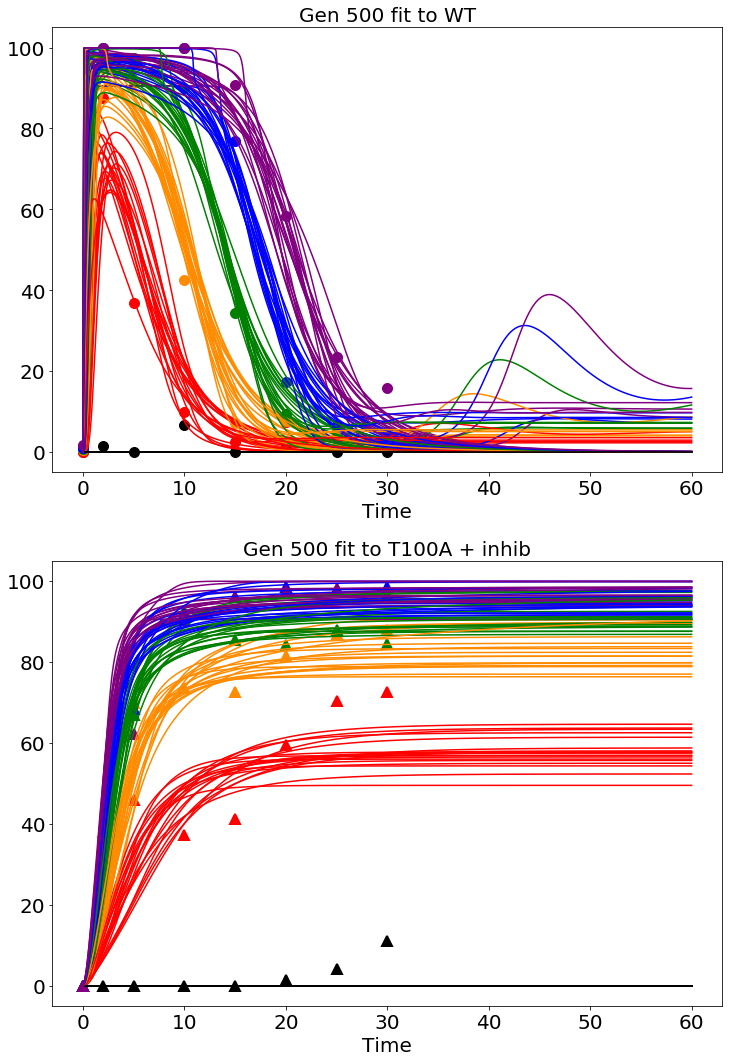

In [331]:
plt_param_behaviors(mapk_wt_data, mapk_t100a_data, gen, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time)

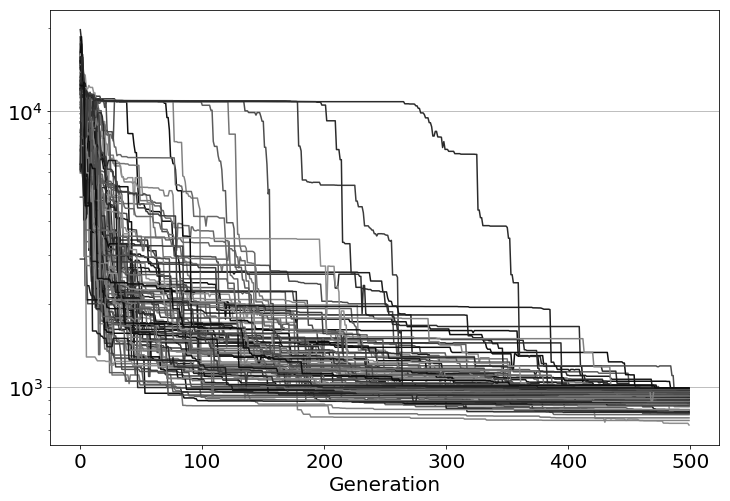

In [317]:
pal = sns.color_palette("Greys", 20)[10:]
sns.set_palette(pal)
plt_mses_gen(gen,mse)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


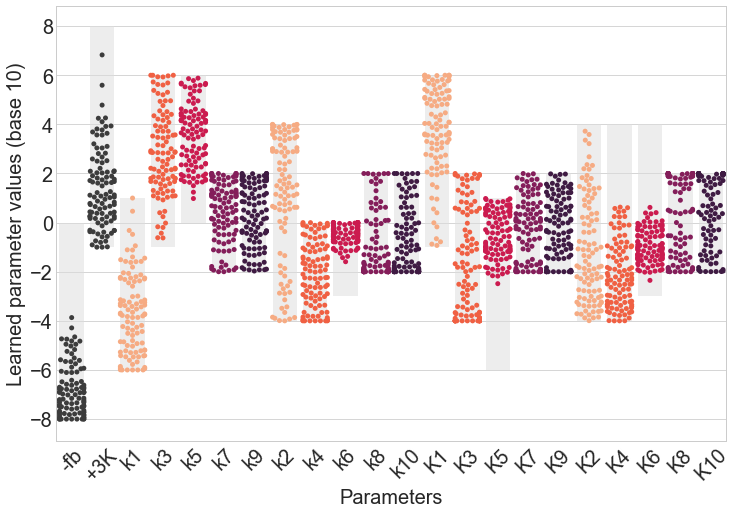

In [314]:
# positive 3db7d6
# negative ee9537
# hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] + rocket[::-1] + rocket[::-1]+ rocket[::-1]+ rocket[::-1]

plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M)

In [327]:
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist

In [341]:
# # signal separated
# df_wt = []
# df_t100a = []
# for idx, sig in enumerate(params_constants[-1]):
#     _data = []
#     for params in top_params:
#         params_c = params_constants[:-1]+[sig]
#         data = simulate_wt_experiment(initals, params_c, params, time)
#         active = (data[:,2])/params_constants[2]*100
#         _data.append(active)
# #         plt.plot(time, active, color=color_palette[idx])
#     # ax1.set_ylim(0, 100)
# #         plt.xlim(0,60)
# #     plt.show()
#     df_wt.append(_data)
#     _data = []
#     for params in top_params:
#         params_c = params_constants[:-1]+[sig]
#         data = simulate_t100a_experiment(initals, params_c, params, time)
#         active = (data[:,2])/params_constants[2]*100
#         _data.append(active)
# #         plt.plot(time, active, color=color_palette[idx])
#     # ax1.set_ylim(0, 100)
# #         plt.xlim(0,60)
#     df_t100a.append(_data)
# headers = ['wt 0','wt 150','wt 250','wt 350','wt 450','wt 550','t100a 0','t100a 150','t100a 250','t100a 350','t100a 450','t100a 550']
# # df = pd.DataFrame(df, columns = headers)
# # df.head()

In [347]:
# signal concatenated
df_data = []
for params in top_params:
    _data = []
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment(initals, params_c, params, time)
        active = (data[:,0])/params_constants[0]*100
        _data = np.concatenate((_data,active))
#         plt.plot(time, active, color=color_palette[idx])
    # ax1.set_ylim(0, 100)
#         plt.xlim(0,60)
#     plt.show()
#     df_wt.append(_data)
#     _data = []
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment(initals, params_c, params, time)
        active = (data[:,1])/params_constants[1]*100
        _data = np.concatenate((_data,active))
#         plt.plot(time, active, color=color_palette[idx])
    # ax1.set_ylim(0, 100)
#         plt.xlim(0,60)
#     plt.show()
#     df_wt.append(_data)
#     _data = []
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment(initals, params_c, params, time)
        active = (data[:,2])/params_constants[2]*100
        _data = np.concatenate((_data,active))
#         plt.plot(time, active, color=color_palette[idx])
    # ax1.set_ylim(0, 100)
#         plt.xlim(0,60)
#     plt.show()
#     df_wt.append(_data)
#     _data = []
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_t100a_experiment(initals, params_c, params, time)
        active = (data[:,2])/params_constants[2]*100
        _data = np.concatenate((_data,active))
#         plt.plot(time, active, color=color_palette[idx])
    # ax1.set_ylim(0, 100)
#         plt.xlim(0,60)
    df_data.append(_data)
# headers = ['wt 0','wt 150','wt 250','wt 350','wt 450','wt 550','t100a 0','t100a 150','t100a 250','t100a 350','t100a 450','t100a 550']
df = pd.DataFrame(df_data)
df.head()

0      1      2      3      4      5      6      7      8      9      \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

     ...          14390      14391      14392      14393      14394  \
0    ...      96.457139  96.457289  96.457437  96.457584  96.457730   
1    ...      90.548073  90.548073  90.548073  90.548074  90.548074   
2    ...      98.443121  98.444325  98.445525  98.446720  98.447911   
3    ...      93.974922  93.975128  93.975332  93.975535  93.975735   
4    ...      98.518784  98.519142  98.519497  98.519850  98.520201   

       14395      14396      14397      14398      14399  
0  96.457874  96.458017  96.458159  96.458300  96.458439  
1  90.548074  90.548075  90.548075  90.548075  90.548076  
2  98.449096  98.450277  98.451454  98.452627  98.453794  
3  93.975934  93.976131  93.976326  93.976519  93.976711  
4  98.520550  98.520897  98.521241  98.521584  98.521925  

[5 rows x 14400 columns]

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


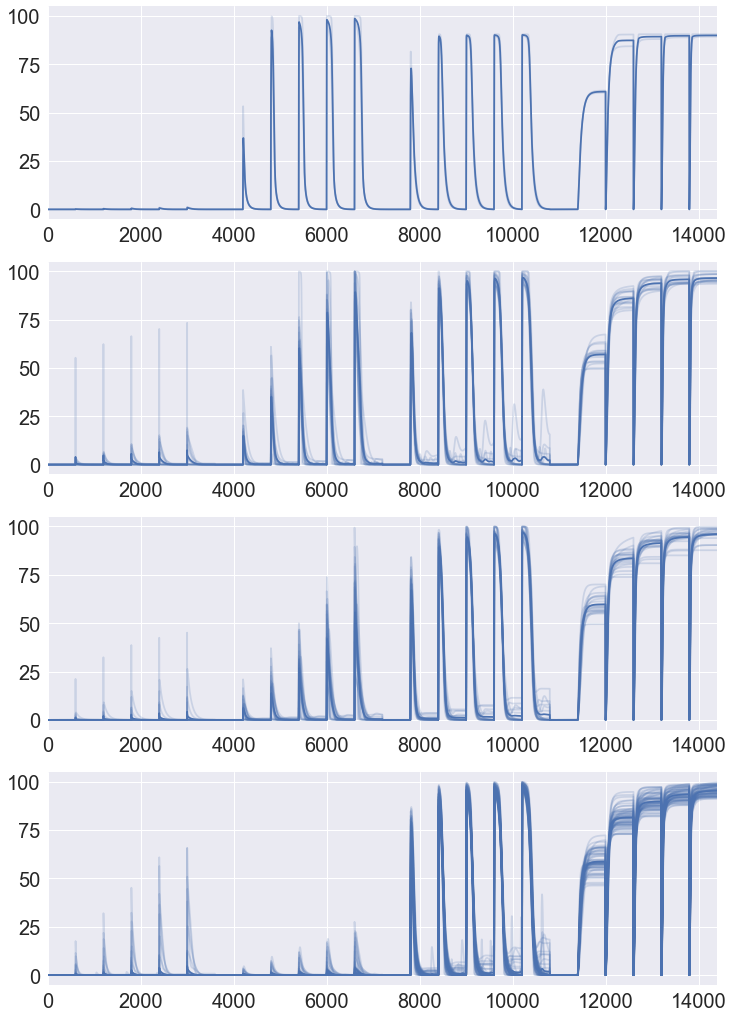

In [349]:
tps = [x for x in range(600*6*4)]

#get pairwise distance among all timeseries
# for data in df_data:
#     print(len(data))
pairwise = pdist(df_data, metric='euclidean')

#calculate a linkage matrix minimizing variance in each cluster
Z = hac.linkage(df_data, method='ward')
#     print(pairwise)
cluster = hac.fcluster(Z,t=4,criterion='maxclust')

c, coph_dists = hac.cophenet(Z,pairwise)

df = pd.DataFrame(df_data)

clust_num = 4

sns.set(font_scale = 2)
plt.rcParams['figure.figsize'] = [12.0, 18.0]
fig, axs = plt.subplots(clust_num,1)
sns.tsplot(data=df.loc[cluster==1,:].values, time = tps, err_style="unit_traces",ax=axs[0])
if df.loc[cluster==2,:].values.any():
    sns.tsplot(data=df.loc[cluster==2,:].values, time = tps, err_style="unit_traces",ax=axs[1])
    sns.tsplot(data=df.loc[cluster==3,:].values, time = tps, err_style="unit_traces",ax=axs[2])
    sns.tsplot(data=df.loc[cluster==4,:].values, time = tps, err_style="unit_traces",ax=axs[3])
plt.show()

In [350]:
df_params_values = df_top_params_log.copy()
color = [0,1,2,3,4]
for x in range(5):
    for idx in df_params_values.index:
        if idx in df.loc[cluster==x,:].index:
            df_params_values.loc[idx,'cluster'] = color[x]
# x = sns.swarmplot(x='param',y='vals', data = df_top_params_log_M)
df_params_values.head()


-fb       +3K        k1        k3        k5        k7        k9  \
0 -8.000000  1.765398 -4.593237  4.959752  1.757756  0.016887  1.913919   
1 -7.511237  0.380694 -5.992642  2.837825  2.756386  0.107414  0.406856   
2 -6.891193 -0.905923 -5.283919  0.924922  4.955870 -1.164855  0.857491   
3 -6.582268 -0.373707 -5.426479  5.974592  2.947871  1.567632 -0.280457   
4 -6.911657 -0.986800 -5.998650  5.687074  1.239154  0.167966  0.845917   

         k2        k4        k6   ...           K3        K5        K7  \
0  3.789825 -1.775574 -0.017828   ...    -3.800269 -1.502427 -1.599549   
1 -3.864657 -1.001613 -0.439776   ...    -3.997134  0.705684 -1.951504   
2  0.524989 -3.375972 -0.050856   ...    -0.665397 -0.064473  0.327821   
3  0.945697 -3.033800 -0.117747   ...    -3.996975 -1.143886  1.351701   
4 -1.864801 -1.883771 -0.165745   ...    -3.710417 -1.872018  0.815846   

         K9        K2        K4        K6        K8       K10  cluster  
0  1.360272 -0.105363 -0.992496 -0.553661 -1.748268  1.958536      3.0  
1 -1.999994 -3.095608 -1.745185 -0.804626  1.999941  1.999885      1.0  
2  0.671919  1.306783 -3.633619 -1.298101 -1.213853  0.413709      4.0  
3 -1.999992 -3.632830 -2.336112 -0.516257  1.999714  1.998710      4.0  
4  0.651275 -3.230536 -1.170822 -0.431890 -1.689187  1.939632      2.0  

[5 rows x 23 columns]

In [351]:
cluster_marker=pd.Series()
for x in range(21):
    _marker = df_params_values['cluster']
    cluster_marker = cluster_marker.append(_marker)
_range = [x for x in range(2100 )]
cluster_marker.index = _range
data_swarm_cluster = df_top_params_log_M.copy()
data_swarm_cluster['cluster'] = cluster_marker


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


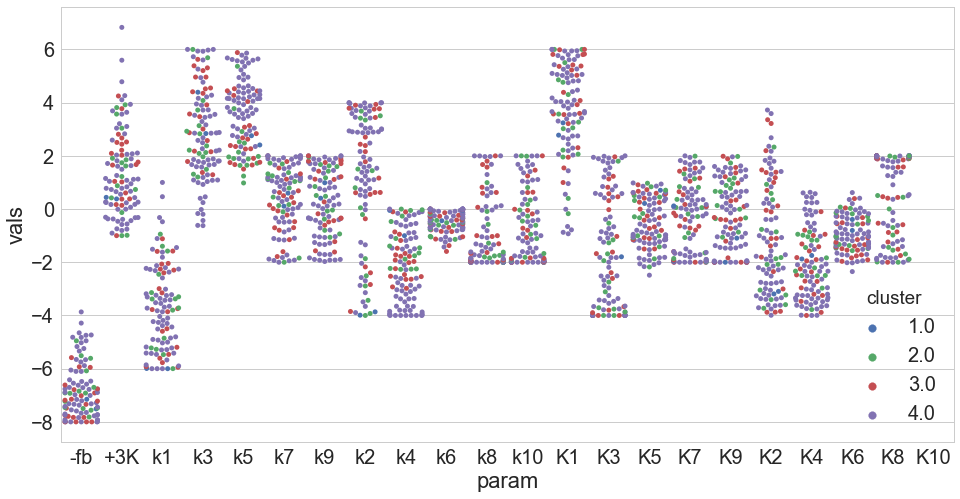

In [352]:
plt.rcParams['figure.figsize'] = [16.0, 8.0]
with sns.axes_style("whitegrid"):
    x = sns.swarmplot(x='param',y='vals', data = data_swarm_cluster, hue='cluster')

# Plot all MSEs

In [ ]:
colors = ['#A9A9A9','#e84728','#1f77b4','#94ddaa']  
mses = [last_mses_an_0D, last_mses_a3_0D, last_mses_a2_0D, last_mses_a1_0D]        
plot_mses(['No +fb', '+fb MAP3K', '+fb MAP2K', '+fb MAPK'], mses, 0.25, colors)

In [ ]:
colors = ['#A9A9A9','#e84728','#1f77b4','#94ddaa']  
mses = [last_mses_an_1D, last_mses_a3_1D, last_mses_a2_1D, last_mses_a1_1D]        
plot_mses(['No +fb', '+fb MAP3K', '+fb MAP2K', '+fb MAPK'], mses, 0.25, colors)

In [ ]:
colors = ['#A9A9A9','#e84728','#1f77b4','#94ddaa']  
mses = [last_mses_an_2D, last_mses_a3_2D, last_mses_a2_2D, last_mses_a1_2D]        
plot_mses(['No +fb', '+fb MAP3K', '+fb MAP2K', '+fb MAPK'], mses, 0.25, colors)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


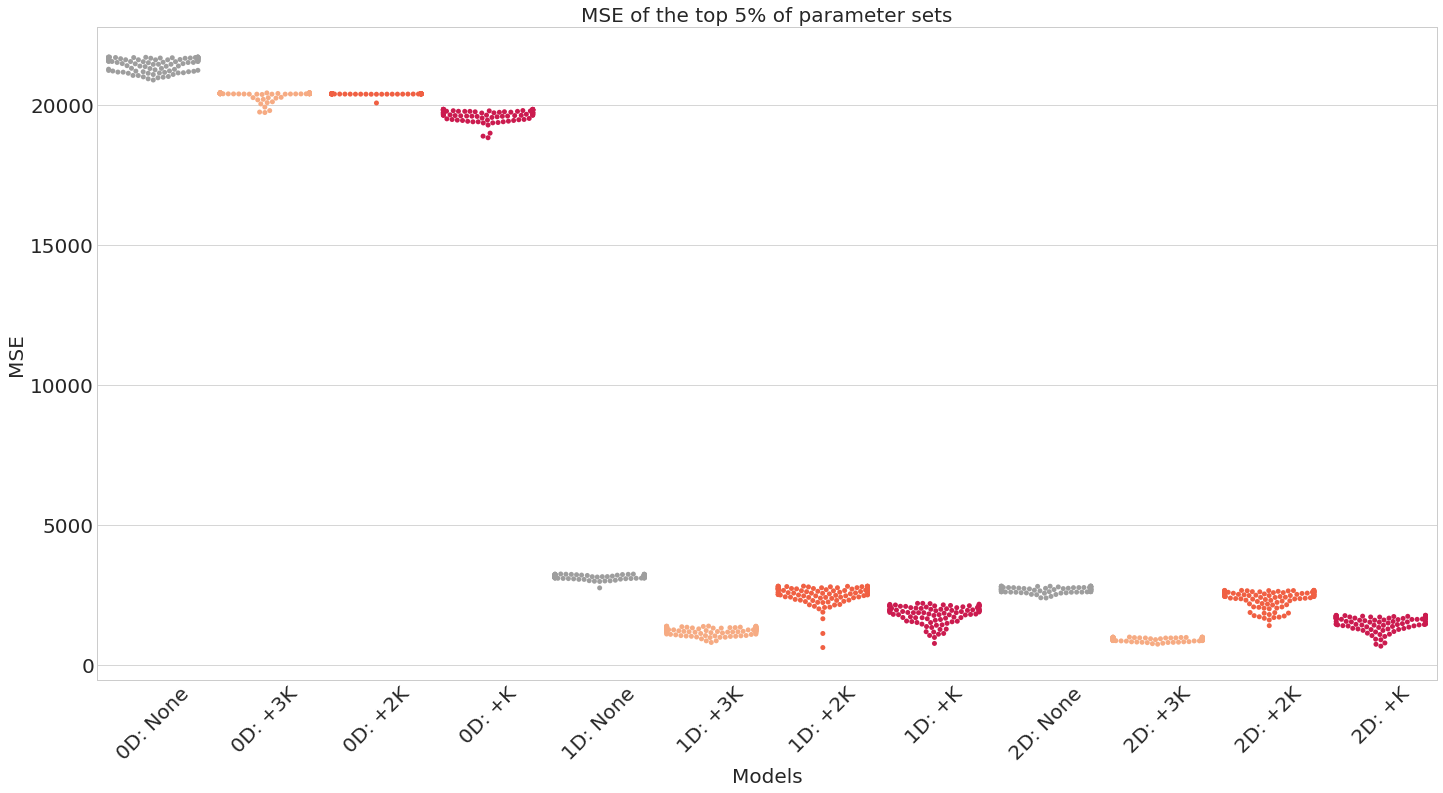

In [157]:
plt.rcParams['figure.figsize'] = [24.0, 12.0]
rocket = sns.color_palette("rocket", 5)#[::-1][:4]
rocket = rocket.as_hex()
rocket[::-1][:4]*4
colors = ['#9e9e9e'] + rocket[::-1][:3] + ['#9e9e9e'] + rocket[::-1][:3] + ['#9e9e9e'] + rocket[::-1][:3] 

# param_col = sns.set_palette(colors)

mses = [last_mses_an_0D, last_mses_a3_0D, last_mses_a2_0D, last_mses_a1_0D, 
        last_mses_an_1D, last_mses_a3_1D, last_mses_a2_1D, last_mses_a1_1D, 
        last_mses_an_2D, last_mses_a3_2D, last_mses_a2_2D, last_mses_a1_2D]        
plot_mses(['0D: None', '0D: +3K', '0D: +2K', '0D: +K',
           '1D: None', '1D: +3K', '1D: +2K', '1D: +K',
           '2D: None', '2D: +3K', '2D: +2K', '2D: +K'], mses, 0.05, colors,'mses_all')
# plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/mses_all.png",dpi=300)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


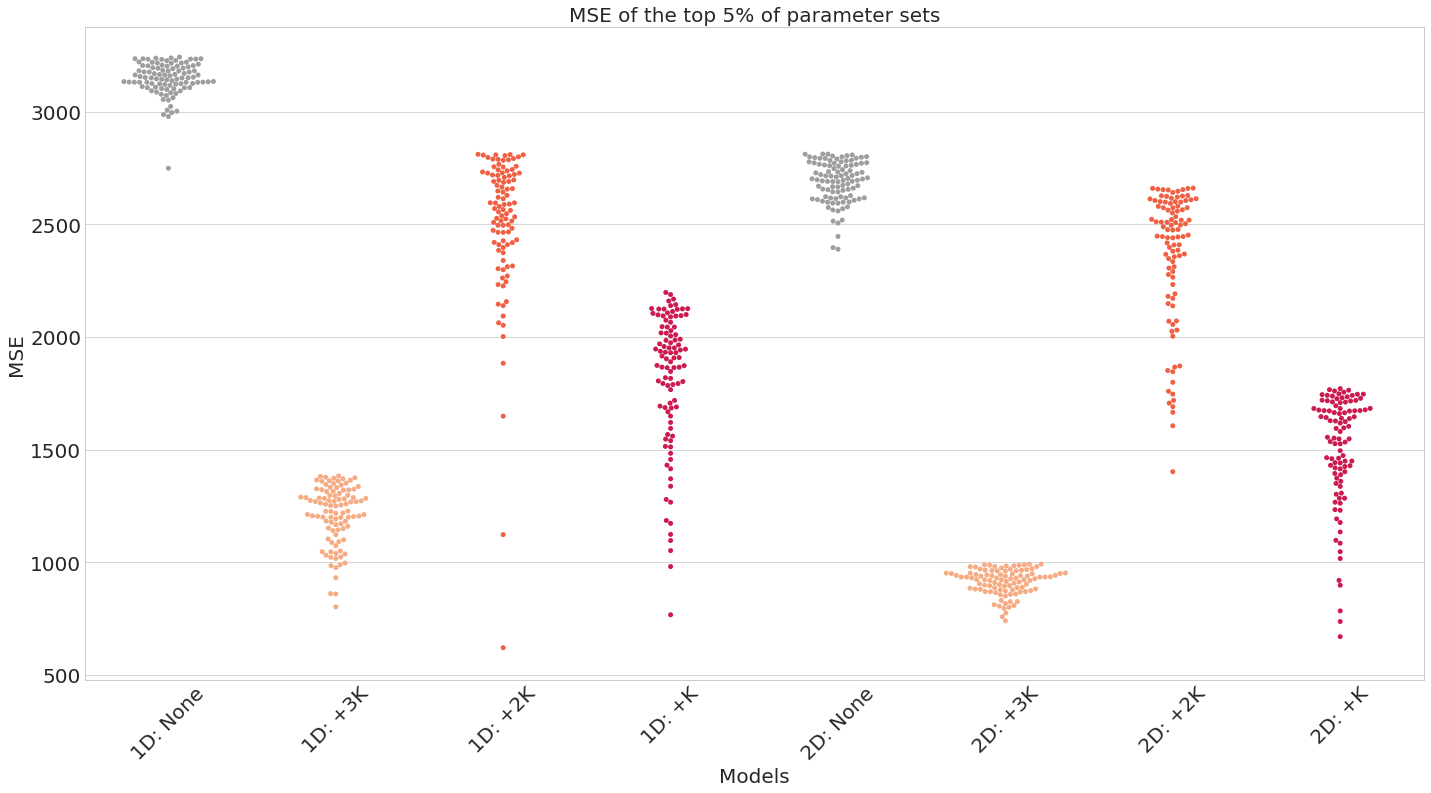

In [132]:
# plt.rcParams['figure.figsize'] = [24.0, 12.0]
# rocket = sns.color_palette("rocket", 5)#[::-1][:4]
# rocket = rocket.as_hex()
# rocket[::-1][:4]*4
colors = ['#9e9e9e'] + rocket[::-1][:3] + ['#9e9e9e'] + rocket[::-1][:3] 

# param_col = sns.set_palette(colors)

mses = [ 
        last_mses_an_1D, last_mses_a3_1D, last_mses_a2_1D, last_mses_a1_1D, 
        last_mses_an_2D, last_mses_a3_2D, last_mses_a2_2D, last_mses_a1_2D]        
plot_mses([
           '1D: None', '1D: +3K', '1D: +2K', '1D: +K',
           '2D: None', '2D: +3K', '2D: +2K', '2D: +K'], mses, 0.05, colors,'181024/mses_delay')

# Extra

## Plot MAP2K

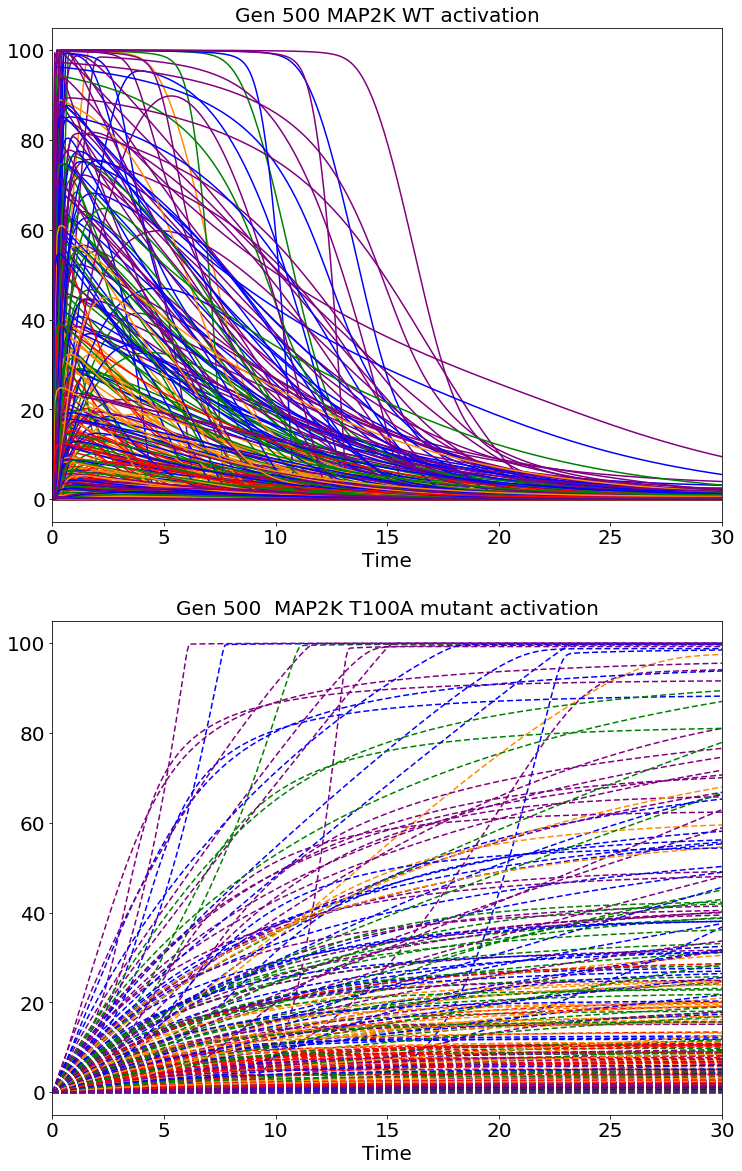

In [324]:
dt = 0.1
steps = 300
time = np.linspace(0,dt*steps,steps)

#initialize figure:
plt.clf()
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,20))

#plot 1
title_text = 'Gen ' + str(gen) + ' MAP2K WT activation'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
# ax1.set_ylabel('gene expression', fontsize=20)
# ax1.set_xlim([0,150])1
# ax1.set_ylim([0,15])
color_palette = ['#000000','#ff0000','#FF8C00','#008000','#0000FF','#800080']

# # plot real data:
# for idx, wt_data in enumerate(mapk_wt_data):
#     ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
# #     ax1.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])

# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,1]/params_constants[1]*100
        ax1.plot(time, active, color=color_palette[idx])
# ax1.set_ylim(0, 100)
        ax1.set_xlim(0,30)
# ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')

#plot 2
title_text = 'Gen ' + str(gen) +  '  MAP2K T100A mutant activation'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

# for idx, t100a_data in enumerate(mapk_t100a_data):
#     ax2.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    
# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_t100a_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,1]/params_constants[1]*100
        ax2.plot(time, active, dashes= [4,2], color=color_palette[idx], label = 'ppMAPK at '  + str(sig))
# ax1.set_ylim(0, 100)
        ax2.set_xlim(0,30)
# ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    

plt.show()

## Plot MAP3K

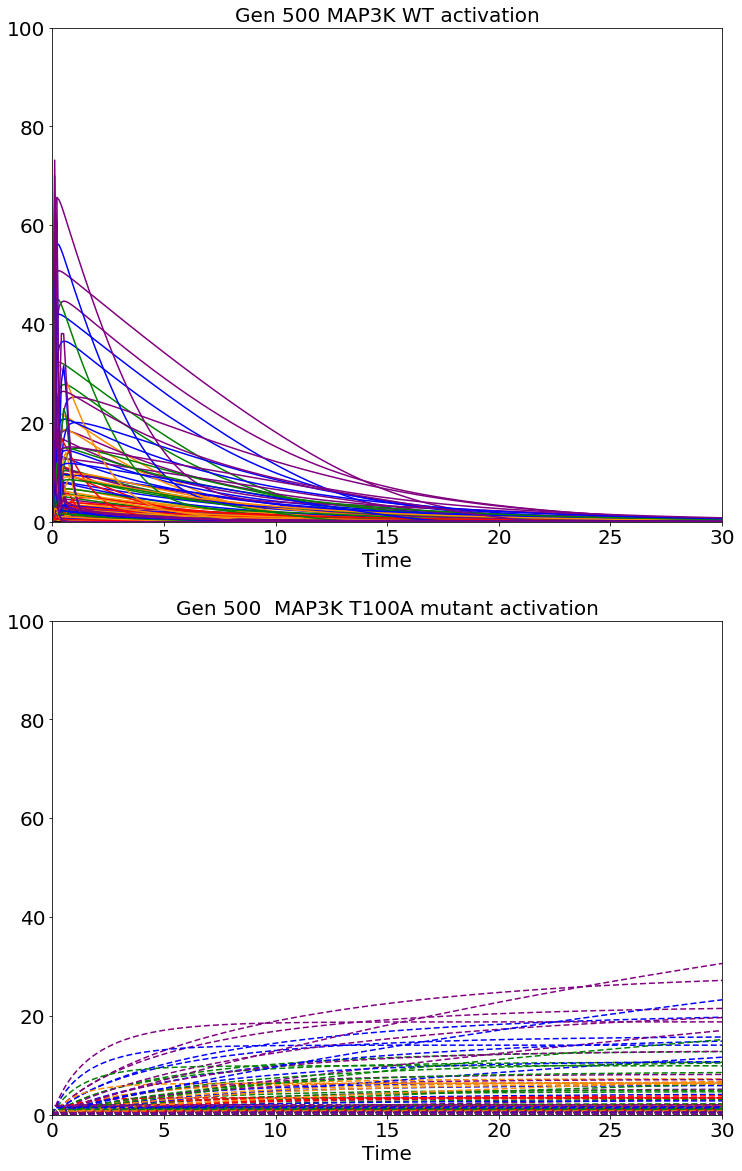

In [325]:
#initialize figure:
plt.clf()
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,20))

#plot 1
title_text = 'Gen ' + str(gen) + ' MAP3K WT activation'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
# ax1.set_ylabel('gene expression', fontsize=20)
# ax1.set_xlim([0,150])1
# ax1.set_ylim([0,15])
# color_palette = sns.color_palette("rocket", 6)[::-1]

# # plot real data:
# for idx, wt_data in enumerate(mapk_wt_data):
#     ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
# #     ax1.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])

# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,0]/params_constants[0]*100
        ax1.plot(time, active, color=color_palette[idx])
# ax1.set_ylim(0, 100)
        ax1.set_xlim(0,30)
        ax1.set_ylim(0,100)
# ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')

#plot 2
title_text = 'Gen ' + str(gen) +  '  MAP3K T100A mutant activation'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

# for idx, t100a_data in enumerate(mapk_t100a_data):
#     ax2.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    
# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_t100a_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,0]/params_constants[0]*100
        ax2.plot(time, active, dashes= [4,2], color=color_palette[idx], label = 'ppMAPK at '  + str(sig))
# ax1.set_ylim(0, 100)
        ax2.set_xlim(0,30)
        ax2.set_ylim(0,100)
# ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    

plt.show()

## Plot Active Cytosolic MAPK

In [ ]:
#initialize figure:
plt.clf()
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(9,12))

#plot 1
title_text = 'Gen ' + str(gen) + ' active cytosolic MAPK'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
# ax1.set_ylabel('gene expression', fontsize=20)
# ax1.set_xlim([0,150])1
ax1.set_ylim([0,100])
color_palette = sns.color_palette("rocket", 6)[::-1]

# # plot real data:
# for idx, wt_data in enumerate(mapk_wt_data):
#     ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
# #     ax1.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])

# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,2]
        ax1.plot(time, active, color=color_palette[idx])
# ax1.set_ylim(0, 100)
        ax1.set_xlim(0,60)
# ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')

#plot 2
title_text = 'Gen ' + str(gen) +  '  active cytosolic MAPK'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

# for idx, t100a_data in enumerate(mapk_t100a_data):
#     ax2.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    
# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_t100a_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,2]
        ax2.plot(time, active, dashes= [4,2], color=color_palette[idx], label = 'ppMAPK at '  + str(sig))
# ax1.set_ylim(0, 100)
        ax2.set_xlim(0,60)
# ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    

plt.show()

## Plot Active Nuclear MAPK

In [ ]:
#initialize figure:
plt.clf()
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(9,12))

#plot 1
title_text = 'Gen ' + str(gen) + ' nuclear MAPK'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
# ax1.set_ylabel('gene expression', fontsize=20)
# ax1.set_xlim([0,150])1
# ax1.set_ylim([0,15])
color_palette = sns.color_palette("rocket", 6)[::-1]

# # plot real data:
# for idx, wt_data in enumerate(mapk_wt_data):
#     ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
# #     ax1.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])

# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,3]
        ax1.plot(time, active, color=color_palette[idx])
# ax1.set_ylim(0, 100)
        ax1.set_xlim(0,60)
# ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')

#plot 2
title_text = 'Gen ' + str(gen) +  '  nuclear MAPK'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

# for idx, t100a_data in enumerate(mapk_t100a_data):
#     ax2.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    
# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_t100a_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,3]
        ax2.plot(time, active, dashes= [4,2], color=color_palette[idx], label = 'ppMAPK at '  + str(sig))
# ax1.set_ylim(0, 100)
        ax2.set_xlim(0,60)
# ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    

plt.show()

## Plot X

In [ ]:
#initialize figure:
plt.clf()
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(9,12))

#plot 1
title_text = 'Gen ' + str(gen) + ' active X'
ax1.set_title(title_text, fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
# ax1.set_ylabel('gene expression', fontsize=20)
# ax1.set_xlim([0,150])1
# ax1.set_ylim([0,15])
color_palette = sns.color_palette("rocket", 6)[::-1]

# # plot real data:
# for idx, wt_data in enumerate(mapk_wt_data):
#     ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
# #     ax1.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])

# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_wt_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,4]
        ax1.plot(time, active, color=color_palette[idx])
# ax1.set_ylim(0, 100)
        ax1.set_xlim(0,60)
# ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')

#plot 2
title_text = 'Gen ' + str(gen) +  '  active X'
ax2.set_title(title_text, fontsize=20)
ax2.set_xlabel('Time', fontsize=20)

# for idx, t100a_data in enumerate(mapk_t100a_data):
#     ax2.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    
# plot evolutionary algorithm data:
for idx in idx_top:
    learned_params = params_from_file[idx][gen]
    for idx, sig in enumerate(params_constants[-1]):
        params_c = params_constants[:-1]+[sig]
        data = simulate_t100a_experiment(initals, params_c, learned_params, time)
#         active = data[:,2] + data[:,3]
        active = data[:,4]
        ax2.plot(time, active, dashes= [4,2], color=color_palette[idx], label = 'ppMAPK at '  + str(sig))
# ax1.set_ylim(0, 100)
        ax2.set_xlim(0,60)
# ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    

plt.show()

## Visualize individual param sets

In [ ]:
color_palette = sns.color_palette("rocket", 6)[::-1]

for i, params in enumerate(top_params):
#     beta_1, beta_2, alpha, k1, k2, k3, k4, k5, k6, k7, k8, K_1, K_2, K_3, K_4, K_5, K_6, K_7, K_8, kn, kc = params
#     params = beta_1, beta_2, 0, k1, k2, k3, k4, k5, k6, k7, k8, K_1, K_2, K_3, K_4, K_5, K_6, K_7, K_8, 0, kc
    #plot real data:
    for idx, (wt_data,t100a_data) in enumerate(zip(mapk_wt_data, mapk_t100a_data)):
        plt.plot(mapk_time, wt_data, 'o', markersize=10, color=color_palette[idx])
        plt.plot(mapk_time, t100a_data, '+', mew=2, markersize=10, color=color_palette[idx])
    for idx, signal in enumerate(s):
        data = odeint(b0_D, initals, time, args=(params_constants[:-1]+[signal], params))
        active = data[:,2]+data[:,3]
        plt.plot(time, active, label=str(signal)+' WT active', color=color_palette[idx])
#         plt.plot(time, data[:,4], dashes=[2, 2], label=str(signal)+' X')
        data = simulate_t100a_experiment(initals, params_constants[:-1]+[signal], params, time)
        active = data[:,2]+data[:,3]
        plt.plot(time, active, label=str(signal)+' T100A active', dashes= [4,2], color=color_palette[idx])
#         plt.plot(time, data[:,3], label=str(signal)+' MAPKn')
    plt.title(f'Param set {i}')
    plt.legend(bbox_to_anchor=[1, 0.5], loc='center left')
#     plt.ylim(0,100)
    plt.show()

## Compare parameter correlations

In [ ]:
top_params_T = np.asarray(top_params).T

# idx = 18
for idx in range(len(top_params_T)):
    for i in range(len(top_params_T)):
        corr = np.corrcoef(top_params_T[idx],top_params_T[i])[0][1]
        if abs(corr) > 0.6 and abs(corr) < 0.999:
            print(labelnames[idx] + ' vs. '+ labelnames[i])
            print(np.corrcoef(top_params_T[idx],top_params_T[i])[0][1])
#     fig, (ax1,ax2) = plt.subplots(1, 2, figsize= (16,6))
#     ax1.scatter(top_params_T[idx],top_params_T[i])
#     ax1.set_ylabel(labelnames[i])
#     ax1.set_title('Raw')
#     ax2.semilogy(top_params_T[idx],top_params_T[i],'o')
#     ax2.set_xscale('log')
#     ax2.set_title('Log')
#     plt.show()


In [ ]:
idx = 0
for i in range(len(top_params_T)):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize= (16,6))
    ax1.scatter(top_params_T[idx],top_params_T[i])
    ax1.set_ylabel(labelnames[i])
    ax1.set_title('Raw')
    ax2.semilogy(top_params_T[idx],top_params_T[i],'o')
    ax2.set_xscale('log')
    ax2.set_title('Log')
    plt.show()


# Model investigation

In [ ]:
top_params = [([new_params[i][x] for i in range(len(new_params))]) for x in idx_top]

In [ ]:
print(top_params[0])
beta_0,    k0, k1, k3, k5, k7,    k2, k4, k6, k8,    kn, kc,    K_1, K_3, K_5, K_7,    K_2, K_4, K_6, K_8,   X_t = top_params[0]
top_params[0] = beta_0,    k0, k1, .1, k5, k7,    k2, k4, k6, k8,    kn, kc,    K_1, K_3, K_5, K_7,    K_2, K_4, K_6, K_8,   X_t
for idx, sig in enumerate(params_constants[-1]):
    params_c = params_constants[:-1]+[sig]
    data = simulate_wt_experiment(initals, params_c, top_params[0], time)
    active = (data[:,2] + data[:,3])/params_constants[2]*100
    plt.plot(time, active, color=color_palette[idx])
    plt.ylim(0,100)

# Results Notes 